# Deep Learning in Image Analysis
## A Graduate-Level Textbook Notebook

**Notation conventions used throughout:**
- Scalars: lowercase italic, e.g. $x, w, b$
- Vectors: bold lowercase, e.g. $\mathbf{x}, \mathbf{w}$
- Matrices/Tensors: bold uppercase, e.g. $\mathbf{X}, \mathbf{W}$
- The $(i,j)$ element of matrix $\mathbf{A}$: $A_{ij}$ or $[\mathbf{A}]_{ij}$
- Convolution operator: $*$
- Hadamard (element-wise) product: $\odot$
- $\mathbb{R}^{H \times W}$: the space of real-valued $H \times W$ matrices (e.g. grayscale images)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.colors import Normalize
from scipy.signal import convolve2d
from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings('ignore')
import torch

# Reproducibility
np.random.seed(42)

# Plotting style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

---
## Chapter 1 — Images as Mathematical Objects

### 1.1 The Formal Definition of a Digital Image

A **grayscale digital image** is a function
$$
f : \Omega \to \mathbb{R}, \quad \Omega = \{0,1,\ldots,H-1\} \times \{0,1,\ldots,W-1\}
$$
where $\Omega$ is the discrete spatial domain, $H$ is the number of rows (height), and $W$ is the number of columns (width). We write $f(i, j)$ or equivalently $f_{ij}$ for the **intensity value** (pixel value) at row $i$, column $j$.

Equivalently, we represent $f$ as a matrix $\mathbf{F} \in \mathbb{R}^{H \times W}$.


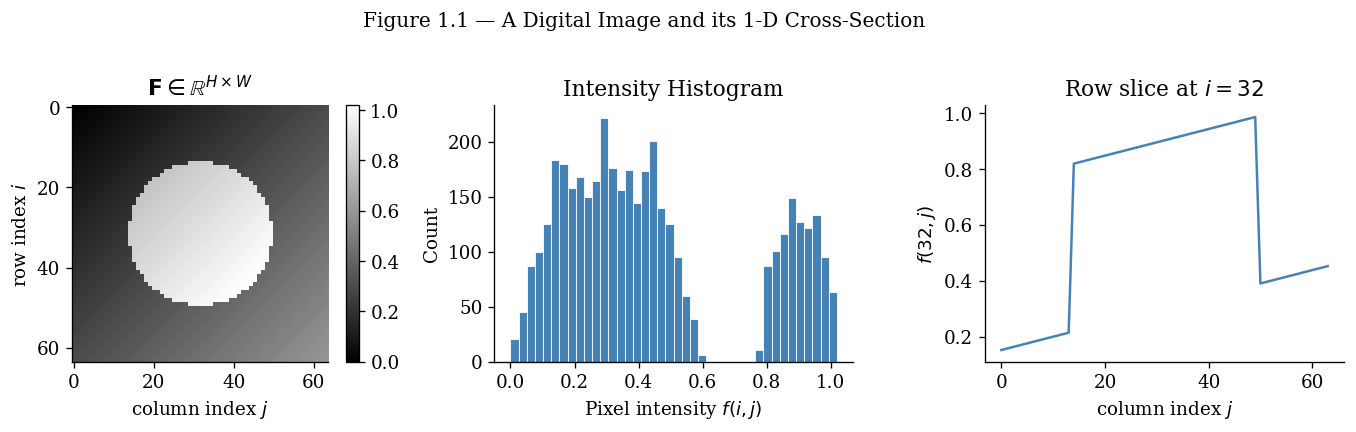

Image shape (H, W)       = (64, 64)
As a batch tensor (N,C,H,W) = (1, 1, 64, 64)
Total parameters (pixels) = 4096


In [45]:
def make_test_image():
    """Synthetic grayscale image: diagonal gradient + a disk."""
    H, W = 64, 64
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(x, y)
    img = 0.3 * (xx + yy)  # gradient
    # add a disk
    img += 0.6 * ((xx - 0.5)**2 + (yy - 0.5)**2 < 0.08).astype(float)
    return img

img = make_test_image()

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Image display
im = axes[0].imshow(img, cmap='gray', origin='upper')
axes[0].set_title(r'$\mathbf{F} \in \mathbb{R}^{H \times W}$')
axes[0].set_xlabel('column index $j$')
axes[0].set_ylabel('row index $i$')
plt.colorbar(im, ax=axes[0], fraction=0.046)

# Pixel value distribution
axes[1].hist(img.ravel(), bins=40, color='steelblue', edgecolor='white', linewidth=0.5)
axes[1].set_xlabel('Pixel intensity $f(i,j)$')
axes[1].set_ylabel('Count')
axes[1].set_title('Intensity Histogram')

# Row slice to show 1-D signal
row_idx = 32
axes[2].plot(img[row_idx, :], color='steelblue', lw=1.5)
axes[2].set_xlabel('column index $j$')
axes[2].set_ylabel(f'$f({row_idx}, j)$')
axes[2].set_title(f'Row slice at $i={row_idx}$')

plt.suptitle('Figure 1.1 — A Digital Image and its 1-D Cross-Section', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

print(f'Image shape (H, W)       = {img.shape}')
print(f'As a batch tensor (N,C,H,W) = (1, 1, {img.shape[0]}, {img.shape[1]})')
print(f'Total parameters (pixels) = {img.size}')

A **colour image** introduces a third axis:
$$
\mathbf{F} \in \mathbb{R}^{C \times H \times W}
$$
where $C$ is the number of **channels** (e.g. $C=3$ for RGB, $C=1$ for grayscale). This three-dimensional array is called a **tensor**.


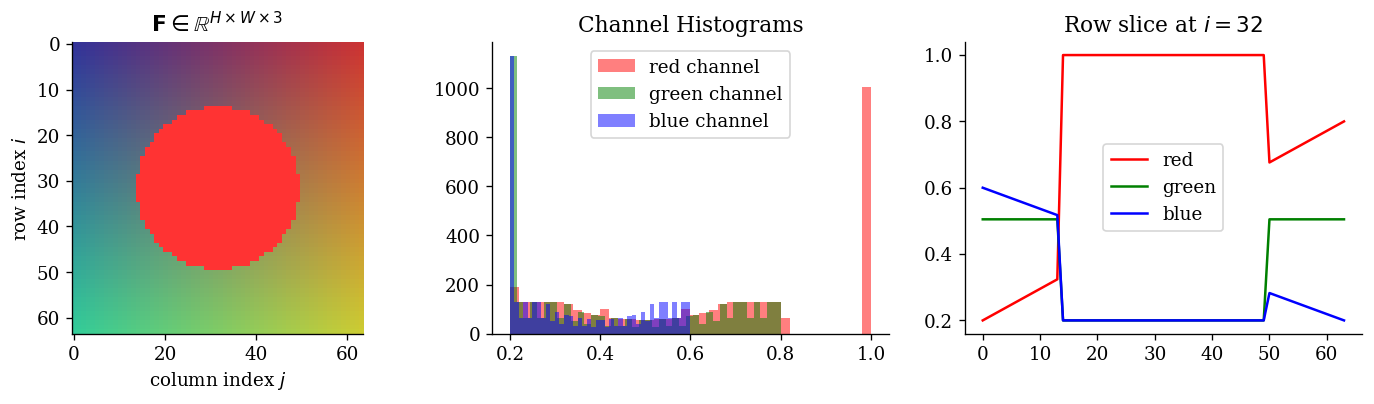

Image shape (H,W,C) = (64, 64, 3)
Tensor form (N,C,H,W) = (1,3,64,64)


In [46]:
import numpy as np
import matplotlib.pyplot as plt


def make_test_image_rgb():
    """Synthetic colour image:
       - coloured gradient background
       - coloured circular object
    """

    H, W = 64, 64
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(x, y)

    # --------------------------------------------------
    # Background colour (gradient)
    # --------------------------------------------------
    R_bg = 0.2 + 0.6 * xx          # red increases left→right
    G_bg = 0.2 + 0.6 * yy          # green increases top→bottom
    B_bg = 0.6 - 0.4 * xx          # blue decreases left→right

    # stack background
    rgb = np.stack([R_bg, G_bg, B_bg], axis=-1)

    # --------------------------------------------------
    # Circular object (new colour)
    # --------------------------------------------------
    disk = (xx - 0.5)**2 + (yy - 0.5)**2 < 0.08

    circle_colour = np.array([1.0, 0.2, 0.2])  # reddish disk

    rgb[disk] = circle_colour

    return rgb


img_rgb = make_test_image_rgb()

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# RGB image
axes[0].imshow(img_rgb, origin='upper')
axes[0].set_title(r'$\mathbf{F} \in \mathbb{R}^{H \times W \times 3}$')
axes[0].set_xlabel('column index $j$')
axes[0].set_ylabel('row index $i$')

# Channel histograms
colors = ['red', 'green', 'blue']
for c in range(3):
    axes[1].hist(
        img_rgb[..., c].ravel(),
        bins=40,
        alpha=0.5,
        color=colors[c],
        label=f'{colors[c]} channel'
    )

axes[1].set_title('Channel Histograms')
axes[1].legend()

# Row slice
row_idx = 32
for c in range(3):
    axes[2].plot(
        img_rgb[row_idx, :, c],
        color=colors[c],
        label=f'{colors[c]}'
    )

axes[2].set_title(f'Row slice at $i={row_idx}$')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f'Image shape (H,W,C) = {img_rgb.shape}')
print(f'Tensor form (N,C,H,W) = (1,3,{img_rgb.shape[0]},{img_rgb.shape[1]})')

## 1.3 Quantisation and Bit Depth

Real imaging systems measure continuous intensities.
Digital images store only a finite number of intensity levels.

If a pixel uses $b$ bits, then the number of representable values is

$L = 2^b$

Typical bit depths:

| Bit depth | Levels | Usage |
|---|---|---|
| 8-bit | 256 | display images |
| 16-bit | 65,536 | scientific imaging |
| 32-bit float | continuous approximation | computation & deep learning |

Reducing bit depth introduces **quantisation error**.

In [ ]:
H, W = 256, 256

# perfectly smooth gradient
img = np.tile(np.linspace(0,1,W), (H,1))

def quantise(img, bits):
    levels = 2**bits - 1
    return np.round(img*levels)/levels

img2 = quantise(img, 2)
img3 = quantise(img, 3)
img4 = quantise(img, 4)
img8 = quantise(img, 8)

fig, ax = plt.subplots(1,4, figsize=(14,4))

datasets = [img2, img3, img4, img8]
titles = ["2-bit (4 levels)",
          "3-bit (8 levels)",
          "4-bit (16 levels)",
          "8-bit (256 levels)"]

for i in range(4):
    ax[i].imshow(datasets[i],
                 cmap="gray",
                 vmin=0,
                 vmax=1,
                 interpolation="nearest")
    ax[i].axis("off")
    ax[i].set_title(titles[i])

plt.suptitle("Quantisation of a Continuous Intensity Ramp")
plt.show()

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(img[128], label="continuous", lw=3)
plt.plot(img2[128], label="2-bit")
plt.plot(img4[128], label="4-bit")
plt.plot(img8[128], label="8-bit")

plt.legend()
plt.xlabel("pixel index")
plt.ylabel("intensity")
plt.title("Quantisation turns a smooth signal into discrete levels")
plt.show()

### Quantisation Error

Quantisation replaces continuous intensities by discrete levels. If intensities lie in $[I_{\min}, I_{\max}]$, the step size is

$$\Delta=\frac{I_{\max}-I_{\min}}{2^b-1}$$

The rounding error satisfies
$$
|e_q| \le \frac{\Delta}{2}.
$$
Higher bit depth therefore reduces quantisation noise and preserves subtle contrast variations.

In [ ]:
def quantise(img, bits):
    levels = 2**bits - 1
    return np.round(img*levels)/levels

# --- test signal: smooth ramp in [0,1] ---
H, W = 256, 256
img = np.tile(np.linspace(0,1,W), (H,1))

# bit depths to compare
bits_list = [2, 3, 4, 8]

# compute quantised images and errors
qimgs = {b: quantise(img, b) for b in bits_list}
errs  = {b: (img - qimgs[b]) for b in bits_list}

# theoretical bounds
bounds = {b: 0.5/(2**b - 1) for b in bits_list}

def quantise(img, bits):
    levels = 2**bits - 1
    return np.round(img*levels)/levels

# --- test signal: smooth ramp in [0,1] ---
H, W = 256, 256
img = np.tile(np.linspace(0,1,W), (H,1))

# bit depths to compare
bits_list = [2, 3, 4, 8]

# compute quantised images and errors
qimgs = {b: quantise(img, b) for b in bits_list}
errs  = {b: (img - qimgs[b]) for b in bits_list}

# theoretical bounds
bounds = {b: 0.5/(2**b - 1) for b in bits_list}

### 1.2 Batches

In deep learning frameworks, we always work with **batches** of images:
$$
\mathcal{B} \in \mathbb{R}^{N \times C \times H \times W}
$$
where $N$ is the **batch size** — the number of images processed simultaneously. This 4-dimensional tensor is the fundamental unit of computation.


In [ ]:
B, C, H, W = 8, 3, 64, 64
batch = torch.randn(B, C, H, W)
print("Batch tensor shape:", batch.shape)

Batch tensor shape: torch.Size([8, 3, 64, 64])


### 1.3 Slabs

---
## Chapter 2 — The Convolution Operation: Kernels

### 2.1 Motivation: Local Structure in Images

Consider the naive approach: connect every pixel to every neuron in a fully-connected layer. For a $256 \times 256$ image with 1000 output neurons, we need $256^2 \times 1000 = 65{,}536{,}000$ weights. This is both computationally wasteful and statistically poor — there is no reason for a neuron looking at the top-left corner to share anything with a neuron looking at the bottom-right.

Images satisfy two key structural priors:
1. **Spatial locality:** informative patterns (edges, textures) depend only on a small neighbourhood of pixels.
2. **Translation equivariance:** an edge detector that works at position $(i_0, j_0)$ should work equally well at any other position.

Both priors are captured exactly by the **discrete convolution**.


### 2.2 Continuous Convolution: Starting Point

Let $f[n]$ and $g[n]$ be two discrete-time sequences. Their convolution is a new sequence $y[n]$ defined by
$$
y[n] = (f * g)[n] = \sum_{m=-\infty}^{+\infty} f[k] g[n - k]
$$


In continuous mathematics, the convolution of functions $f, g : \mathbb{R} \to \mathbb{R}$ is defined as:
$$
(f * g)(t) = \int_{-\infty}^{+\infty} f(\tau)\, g(t - \tau)\, d\tau
$$
The convolution of two functions measures how much one function overlaps with a shifted and reversed version of another function.
Convolution answers:

How similar is $f$ to a shifted copy of $g$?

**Interpretation:** At each point $t$, we slide $g$ (flipped and shifted) over $f$, and integrate the product. The output is a new function whose value at $t$ measures the degree of overlap between $f$ and the pattern described by $g$.

### 2.3 Discrete 2-D Convolution and Kernels

Discretising and extending to 2-D with a **kernel** (also called a **filter**) $\mathbf{K} \in \mathbb{R}^{k_h \times k_w}$ of height $k_h$ and width $k_w$:

$$
\boxed{(\mathbf{F} * \mathbf{K})(i, j) = \sum_{m=0}^{k_h - 1} \sum_{n=0}^{k_w - 1} F(i+m,\, j+n)\cdot K(k_h - 1 - m,\, k_w - 1 - n)}
$$

**Variable definitions:**
- $\mathbf{F}$: input image of shape $H \times W$
- $\mathbf{K}$: kernel of shape $k_h \times k_w$ — the set of weights to learn
- $(i, j)$: output spatial location (top-left corner of the receptive field)
- $m, n$: kernel offsets
- The kernel is **flipped** along both axes (indices $k_h - 1 - m$ and $k_w - 1 - n$) — this is the difference between convolution and **cross-correlation**

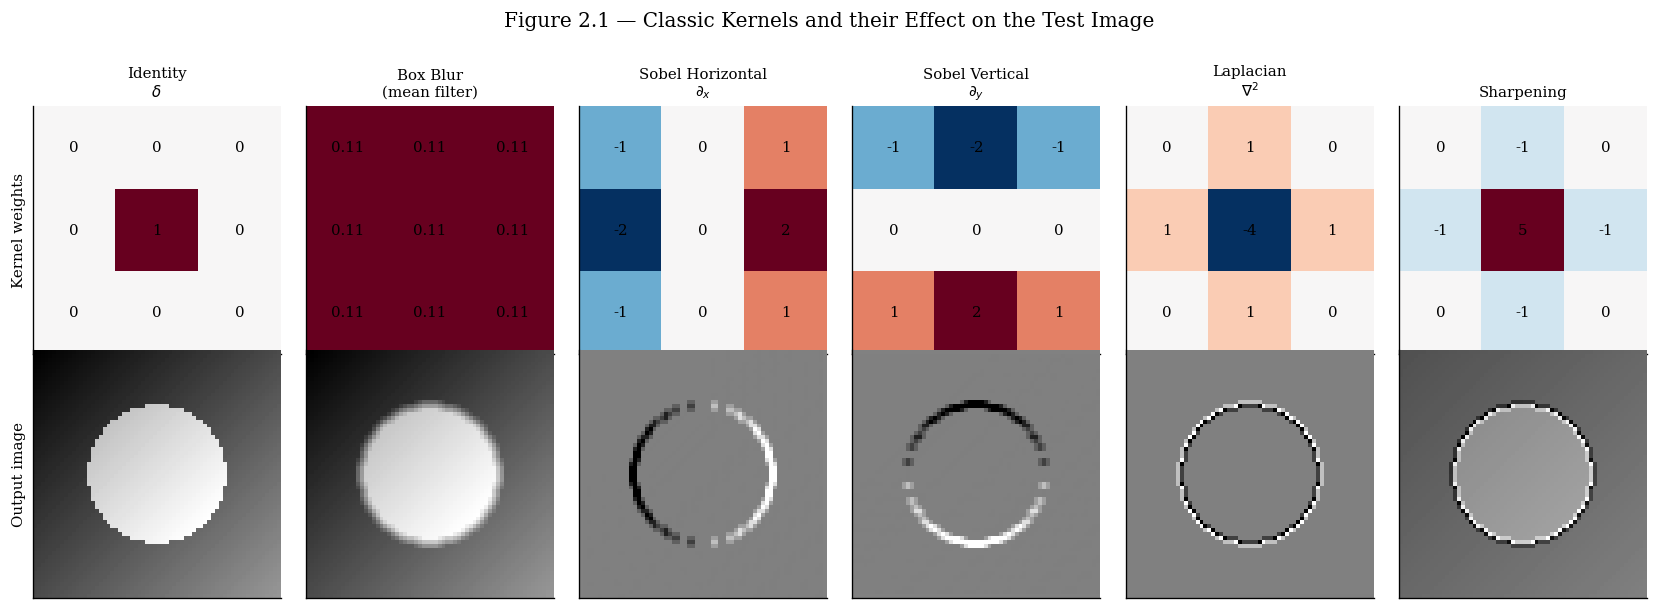

In [47]:
# ----- Kernel zoo: visualise classic hand-crafted kernels -----

kernels = {
    'Identity\n$\\delta$': np.array([[0,0,0],[0,1,0],[0,0,0]], dtype=float),
    'Box Blur\n(mean filter)': np.ones((3,3)) / 9.0,
    'Sobel Horizontal\n$\\partial_x$': np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=float),
    'Sobel Vertical\n$\\partial_y$': np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=float),
    'Laplacian\n$\\nabla^2$': np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=float),
    'Sharpening': np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=float),
}

fig, axes = plt.subplots(2, len(kernels), figsize=(14, 5))

for col, (name, K) in enumerate(kernels.items()):
    # Top row: kernel weights
    vmax = max(abs(K.min()), abs(K.max()))
    im = axes[0, col].imshow(K, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[0, col].set_title(name, fontsize=9)
    axes[0, col].set_xticks([]); axes[0, col].set_yticks([])
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            axes[0, col].text(j, i, f'{K[i,j]:.2g}', ha='center', va='center',
                              fontsize=9, color='black')
    # Bottom row: result of applying kernel to test image
    result = convolve2d(img, K, mode='same', boundary='symm')
    axes[1, col].imshow(result, cmap='gray')
    axes[1, col].set_xticks([]); axes[1, col].set_yticks([])

axes[0, 0].set_ylabel('Kernel weights', fontsize=9)
axes[1, 0].set_ylabel('Output image', fontsize=9)
plt.suptitle('Figure 2.1 — Classic Kernels and their Effect on the Test Image', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

### 2.4 Cross-Correlation (What CNNs Actually Compute)

In practice, deep learning frameworks implement **cross-correlation**, which omits the flip:

$$
\boxed{(\mathbf{F} \star \mathbf{K})(i, j) = \sum_{m=0}^{k_h - 1} \sum_{n=0}^{k_w - 1} F(i+m,\, j+n) \cdot K(m, n)}
$$

Since kernels are **learned**, the flip merely initialises a different parameter—the network learns the correct flipped or unflipped weights regardless. Henceforth, we use $*$ to mean cross-correlation in the CNN sense, following standard deep learning convention.

**Meaning of the equation:** At each output position $(i,j)$, we take the element-wise product between the image patch of size $k_h \times k_w$ starting at $(i,j)$ and the kernel $\mathbf{K}$, then sum all products into a single scalar. This scalar measures **how strongly the local image region matches the pattern encoded in $\mathbf{K}$**.


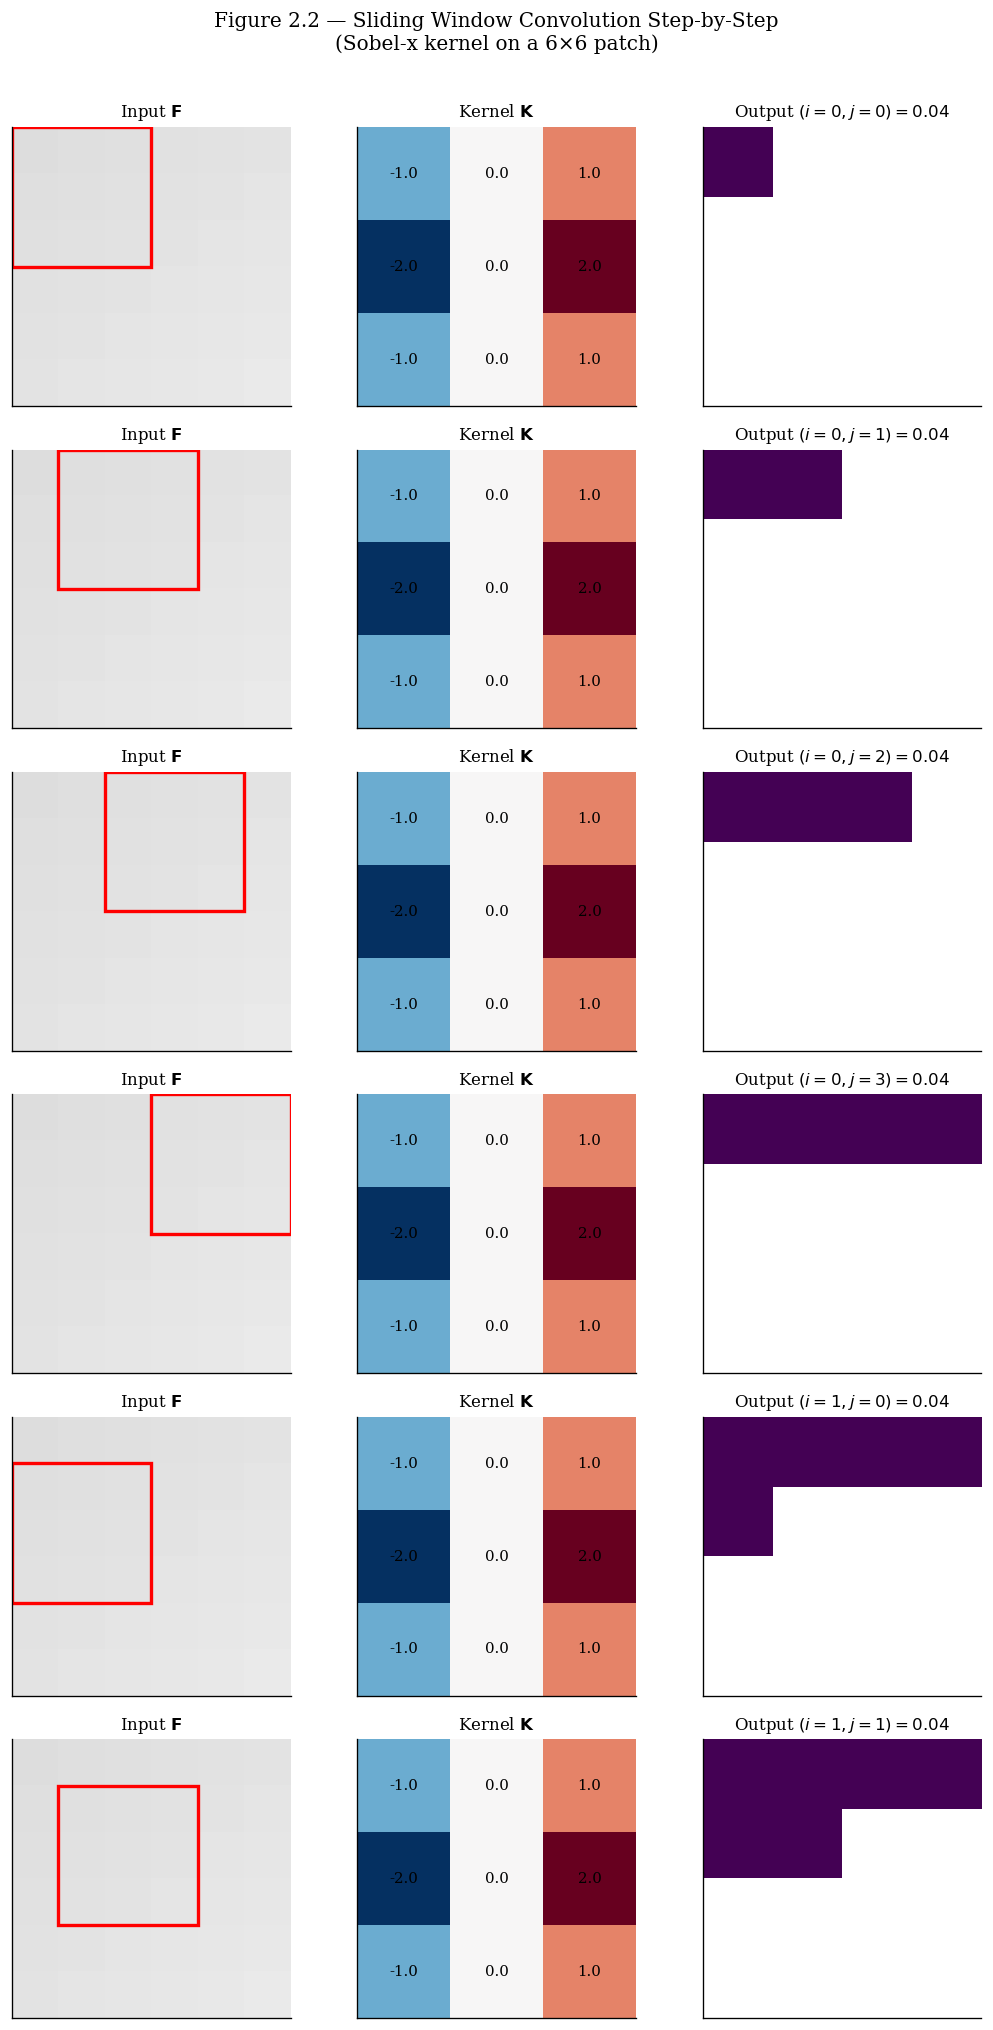

In [48]:
def visualise_conv_step(F, K, i0, j0, ax_img, ax_kernel, ax_out, out_accumulated):
    H, W = F.shape
    kh, kw = K.shape
    patch = F[i0:i0+kh, j0:j0+kw]
    value = (patch * K).sum()

    # Image with sliding window highlighted
    ax_img.imshow(F, cmap='gray', vmin=0, vmax=1)
    rect = Rectangle((j0 - 0.5, i0 - 0.5), kw, kh,
                      linewidth=2, edgecolor='red', facecolor='none')
    ax_img.add_patch(rect)
    ax_img.set_title('Input $\\mathbf{F}$', fontsize=10)
    ax_img.set_xticks([]); ax_img.set_yticks([])

    # Kernel
    vmax = max(abs(K.min()), abs(K.max())) + 1e-6
    ax_kernel.imshow(K, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    for ii in range(kh):
        for jj in range(kw):
            ax_kernel.text(jj, ii, f'{K[ii,jj]:.1f}', ha='center', va='center', fontsize=9)
    ax_kernel.set_title('Kernel $\\mathbf{K}$', fontsize=10)
    ax_kernel.set_xticks([]); ax_kernel.set_yticks([])

    # Output so far
    out_accumulated[i0, j0] = value
    display = out_accumulated.copy()

    # Fix: use output dimensions (Ho, Wo) for the mask so shapes match display
    Ho, Wo = display.shape
    mask = (display == 0) & ~((np.arange(Ho)[:, None] == i0) & (np.arange(Wo)[None, :] == j0))

    display_show = np.ma.masked_where(mask, display)
    ax_out.imshow(display_show, cmap='viridis',
                  vmin=out_accumulated[out_accumulated != 0].min() if out_accumulated.any() else 0,
                  vmax=out_accumulated.max() if out_accumulated.any() else 1)
    ax_out.set_title(f'Output $(i={i0}, j={j0})={value:.2f}$', fontsize=10)
    ax_out.set_xticks([]); ax_out.set_yticks([])

# Use a small 6x6 patch of the test image for clarity
F_small = img[28:34, 28:34]
K_sobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=float)
H_s, W_s = F_small.shape
kh, kw = K_sobel.shape

H_out = H_s - kh + 1
W_out = W_s - kw + 1
out_acc = np.zeros((H_out, W_out))

steps = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1)]
fig, axes = plt.subplots(len(steps), 3, figsize=(9, 2.8 * len(steps)))

for row, (i0, j0) in enumerate(steps):
    visualise_conv_step(F_small, K_sobel, i0, j0, axes[row, 0], axes[row, 1], axes[row, 2], out_acc)

plt.suptitle('Figure 2.2 — Sliding Window Convolution Step-by-Step\n(Sobel-x kernel on a 6×6 patch)', 
             y=1.005, fontsize=12)
plt.tight_layout()
plt.show()

### 2.5 Output Dimensions

With input $\mathbf{F} \in \mathbb{R}^{H \times W}$, kernel $\mathbf{K} \in \mathbb{R}^{k_h \times k_w}$, padding $p$, and stride $s$, the output feature map has dimensions:

$$
\boxed{H_{out} = \left\lfloor \frac{H + 2p - k_h}{s} \right\rfloor + 1, \qquad W_{out} = \left\lfloor \frac{W + 2p - k_w}{s} \right\rfloor + 1}
$$

**Intuition for each term:**
- $H + 2p$: input is padded symmetrically by $p$ pixels on each side, adding $2p$ rows total
- $H + 2p - k_h$: the kernel can start at most this far from the top-left (any further and it would fall outside the padded image)
- Dividing by $s$ counts how many steps of size $s$ fit within that range
- Adding 1 accounts for the starting position itself

**Common special case ("same" padding):** Choose $p = \lfloor k_h / 2 \rfloor$ and $s=1$ to get $H_{out} = H$, $W_{out} = W$ — spatial dimensions are preserved.

### 2.6 Learnable Kernels: From Hand-Crafted to Data-Driven

The kernels shown above (Sobel, Laplacian, etc.) were **designed by hand** based on physical/geometric reasoning. The key insight of CNNs is that better kernels can be **learned from data** via gradient descent.

In a convolutional layer, each kernel $\mathbf{K}^{(f)}$ (for filter index $f = 1, \ldots, F_{out}$) is a parameter tensor. The layer computes:

$$
\mathbf{Y}^{(f)} = \sigma\left(\sum_{c=1}^{C_{in}} \mathbf{X}^{(c)} * \mathbf{K}^{(f,c)} + b^{(f)}\right)
$$

**Variable definitions:**
- $\mathbf{X}^{(c)} \in \mathbb{R}^{H \times W}$: the $c$-th channel of the input
- $\mathbf{K}^{(f,c)} \in \mathbb{R}^{k_h \times k_w}$: kernel connecting input channel $c$ to output channel $f$
- $b^{(f)} \in \mathbb{R}$: scalar bias for output channel $f$
- $\sigma$: element-wise **activation function** (nonlinearity)
- $\mathbf{Y}^{(f)} \in \mathbb{R}^{H_{out} \times W_{out}}$: the $f$-th **feature map**

**Total parameter count for one convolutional layer:**
$$
\#\text{params} = F_{out} \times (C_{in} \times k_h \times k_w + 1)
$$
The $+1$ accounts for the bias. Compare this to a fully-connected layer: $C_{in} H W \times F_{out} H_{out} W_{out}$ — orders of magnitude more parameters for typical image sizes.

**Example:** $C_{in}=3$, $k_h=k_w=3$, $F_{out}=64$ gives $64 \times (27 + 1) = 1792$ parameters.
A fully-connected alternative on a $224 \times 224$ image: $3 \times 224^2 \times 64 \times 224^2 \approx 2.3 \times 10^{12}$ parameters.

### 2.7 Stride: Controlling Spatial Downsampling

The **stride** $s$ is the step size by which the kernel slides across the input. With $s=1$ the kernel moves one pixel at a time (dense sampling). With $s=2$ it moves two pixels, halving the spatial dimensions of the output.

Mathematically, stride modifies the cross-correlation to:
$$
(\mathbf{F} \star_s \mathbf{K})(i, j) = \sum_{m=0}^{k_h - 1} \sum_{n=0}^{k_w - 1} F(si+m,\, sj+n) \cdot K(m, n)
$$

Substituting $si$ for $i$ means only every $s$-th row/column of the output is computed. Stride $>1$ is an alternative to pooling for downsampling.

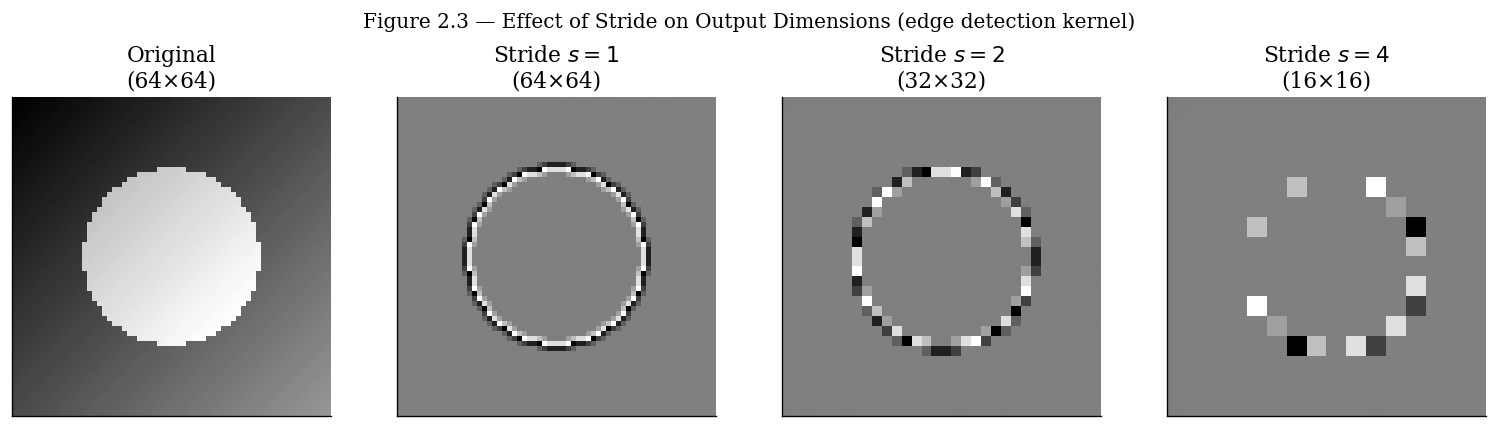

In [49]:
# ----- Effect of stride on output dimensions -----

def apply_conv_with_stride(F, K, stride, padding=0):
    H, W = F.shape
    kh, kw = K.shape
    # pad
    Fp = np.pad(F, padding, mode='edge')
    H_out = (H + 2*padding - kh) // stride + 1
    W_out = (W + 2*padding - kw) // stride + 1
    out = np.zeros((H_out, W_out))
    for i in range(H_out):
        for j in range(W_out):
            out[i, j] = (Fp[i*stride:i*stride+kh, j*stride:j*stride+kw] * K).sum()
    return out

K_edge = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=float)
strides = [1, 2, 4]

fig, axes = plt.subplots(1, len(strides)+1, figsize=(13, 3.5))
axes[0].imshow(img, cmap='gray'); axes[0].set_title('Original\n(64×64)')
axes[0].set_xticks([]); axes[0].set_yticks([])

for ax, s in zip(axes[1:], strides):
    out = apply_conv_with_stride(img, K_edge, stride=s, padding=1)
    ax.imshow(out, cmap='gray')
    H_out, W_out = out.shape
    ax.set_title(f'Stride $s={s}$\n({H_out}×{W_out})')
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Figure 2.3 — Effect of Stride on Output Dimensions (edge detection kernel)', 
             y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

---
## Chapter 3 — Patching: Processing Images in Pieces

### 3.1 Why Patch-Based Processing?

Modern scientific images are often enormous. A single synchrotron X-ray tomography slice may be $2560 \times 2160$ pixels at 32-bit float precision = $\approx 22$ MB. A U-Net processing this image through 4 downsampling levels requires feature maps at multiple resolutions, easily exceeding 10–20 GB of GPU memory.

The solution is **patch-based processing**: decompose the image into smaller overlapping or non-overlapping tiles, process each tile independently through the network, and reassemble the results.

### 3.2 Formal Patch Extraction

Let $\mathbf{F} \in \mathbb{R}^{H \times W}$ be the full image. A **patch** is a rectangular sub-array:

$$
\mathbf{P}_{(i_0, j_0)} = \mathbf{F}[i_0 : i_0 + p_h,\; j_0 : j_0 + p_w] \in \mathbb{R}^{p_h \times p_w}
$$

where $(i_0, j_0)$ is the **top-left corner** of the patch, and $p_h \times p_w$ is the **patch size**.

### 3.3 Overlap and the Stride of Patching

Patches can be extracted with a **patch stride** $s_p$ (not to be confused with the convolution stride $s$). If $s_p < p_h$, patches overlap; if $s_p = p_h$, they tile without overlap.

For a 1-D image of length $L$:
- With stride $s_p$ and patch size $p$, the number of patches is $\left\lfloor \frac{L - p}{s_p} \right\rfloor + 1$
- Overlap per pair of adjacent patches: $p - s_p$ pixels

The total number of patches extracted from an $H \times W$ image is:
$$
N_p = \left(\left\lfloor \frac{H - p_h}{s_p^h} \right\rfloor + 1\right) \times \left(\left\lfloor \frac{W - p_w}{s_p^w} \right\rfloor + 1\right)
$$

### 3.4 Border Effects: Why Overlap Matters for Neural Networks

**Critical observation:** Convolution-based networks have a **receptive field** that grows with depth. A neuron at position $(i,j)$ in a deep layer 'sees' a large region of the original input. Near the borders of a patch, the network cannot see information that lies outside the patch — this causes **border artefacts** in the output.

**Receptive field size** for $L$ stacked convolutional layers each with kernel size $k$ and stride 1:
$$
r = 1 + L \cdot (k - 1)
$$

**Solution:** Add an **overlap** (also called **context** or **halo**) of at least $\lfloor r/2 \rfloor$ pixels on each side of each patch. After processing, discard the border predictions and keep only the central valid region. The overlap $o$ required is:

$$
o \geq \frac{r - 1}{2} = \frac{L(k-1)}{2}
$$

For example: $L=10$ layers, $k=3 \Rightarrow r = 21$, so $o \geq 10$ pixels of overlap needed.

### 3.5 Reassembly: Averaging Overlapping Predictions

When patches overlap, multiple predictions exist for the same pixel. Let $\hat{y}^{(t)}(i,j)$ denote the prediction for pixel $(i,j)$ from patch $t$. The final prediction is:

$$
\hat{y}(i, j) = \frac{\sum_{t : (i,j) \in \mathcal{P}_t} w_t(i,j)\, \hat{y}^{(t)}(i,j)}{\sum_{t : (i,j) \in \mathcal{P}_t} w_t(i,j)}
$$

where $w_t(i,j)$ is a weighting function. Common choices:
- **Uniform:** $w_t(i,j) = 1$ — simple average
- **Gaussian:** $w_t(i,j) = \exp\!\left(-\frac{(i - c_i^t)^2 + (j - c_j^t)^2}{2\sigma^2}\right)$ — downweights border predictions

The Gaussian weighting is preferred when border artefacts are present, as it smoothly de-emphasises the less reliable patch edges.

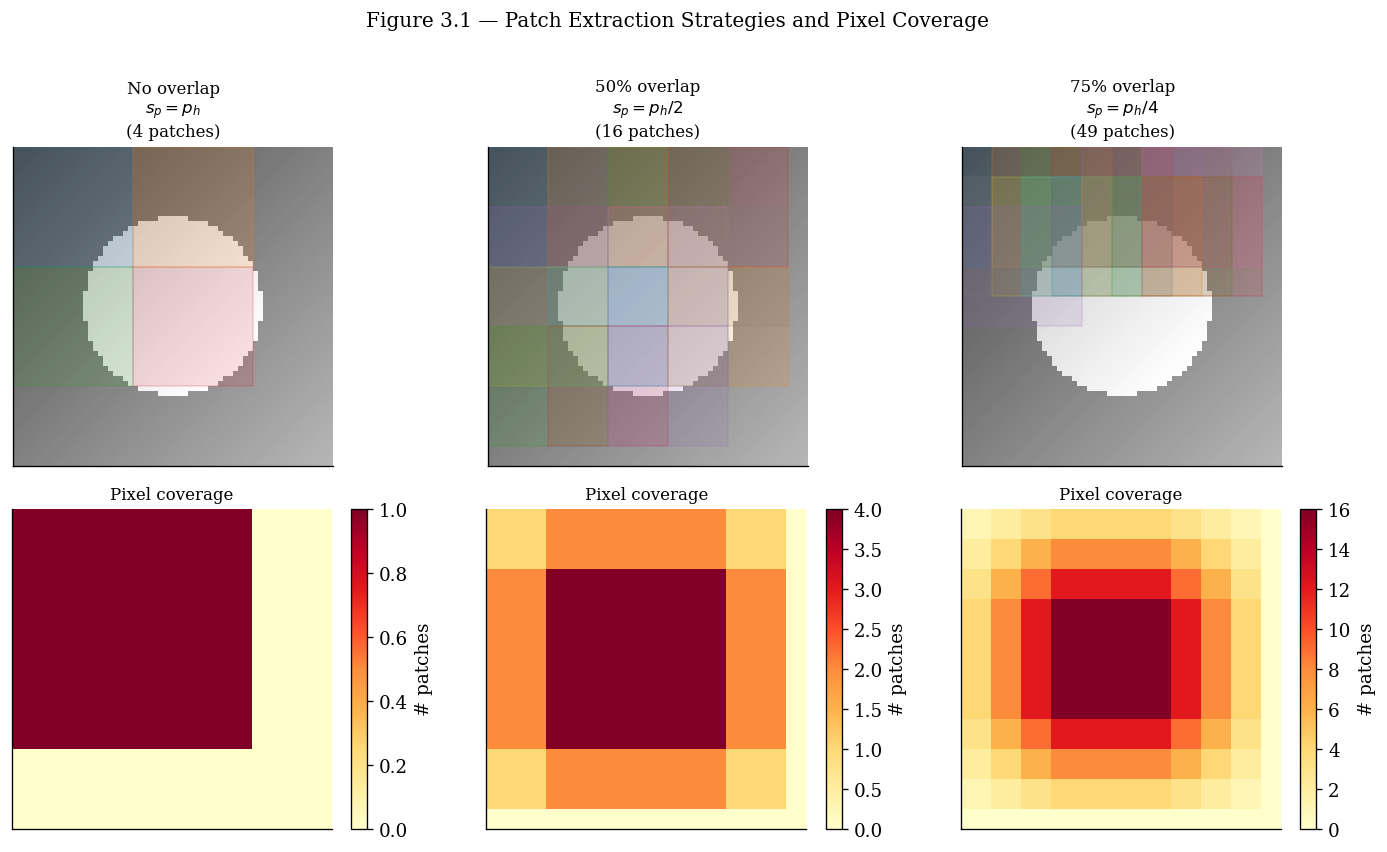

In [50]:
# ----- Visualise patch extraction and overlap -----

def extract_patches(img, patch_size, stride):
    H, W = img.shape
    ph, pw = patch_size
    patches, coords = [], []
    for i in range(0, H - ph + 1, stride):
        for j in range(0, W - pw + 1, stride):
            patches.append(img[i:i+ph, j:j+pw])
            coords.append((i, j))
    return patches, coords

def count_coverage(img_shape, patch_size, stride):
    """How many patches cover each pixel?"""
    H, W = img_shape
    ph, pw = patch_size
    coverage = np.zeros((H, W))
    for i in range(0, H - ph + 1, stride):
        for j in range(0, W - pw + 1, stride):
            coverage[i:i+ph, j:j+pw] += 1
    return coverage

H, W = 64, 64
patch_size = (24, 24)

configs = [
    ('No overlap\n$s_p = p_h$', 24),
    ('50% overlap\n$s_p = p_h/2$', 12),
    ('75% overlap\n$s_p = p_h/4$', 6),
]

fig, axes = plt.subplots(2, len(configs), figsize=(12, 7))

for col, (title, stride) in enumerate(configs):
    patches, coords = extract_patches(img, patch_size, stride)
    coverage = count_coverage((H, W), patch_size, stride)

    # Top: show image with patch grid
    axes[0, col].imshow(img, cmap='gray', alpha=0.7)
    axes[0, col].set_title(f'{title}\n({len(patches)} patches)', fontsize=10)
    axes[0, col].set_xticks([]); axes[0, col].set_yticks([])

    # Draw patch rectangles (first few)
    cmap_patches = plt.cm.tab10
    for k, (i0, j0) in enumerate(coords[:15]):
        rect = Rectangle((j0 - 0.5, i0 - 0.5), patch_size[1], patch_size[0],
                          linewidth=1.2, edgecolor=cmap_patches(k % 10),
                          facecolor=cmap_patches(k % 10), alpha=0.15)
        axes[0, col].add_patch(rect)

    # Bottom: coverage map
    im = axes[1, col].imshow(coverage, cmap='YlOrRd', vmin=0)
    plt.colorbar(im, ax=axes[1, col], fraction=0.046, label='# patches')
    axes[1, col].set_title('Pixel coverage', fontsize=10)
    axes[1, col].set_xticks([]); axes[1, col].set_yticks([])

plt.suptitle('Figure 3.1 — Patch Extraction Strategies and Pixel Coverage', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

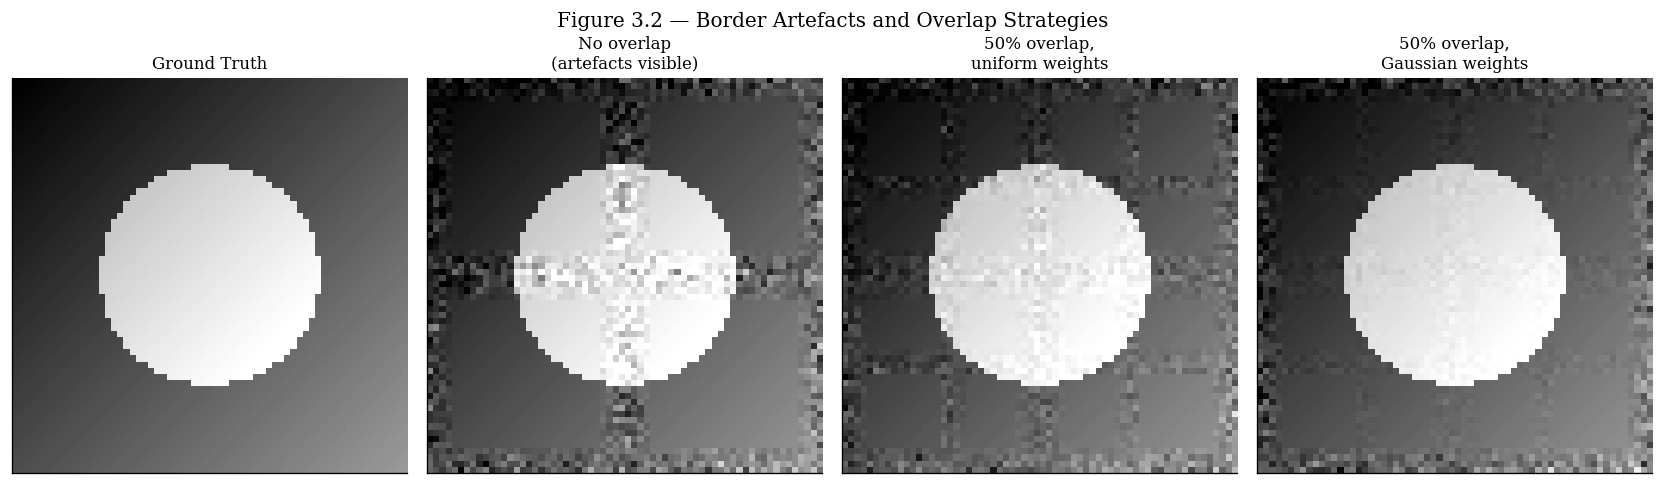

In [51]:
# ----- Demonstrate border artefacts and overlap remedy -----

def gaussian_weight_map(patch_size, sigma_frac=0.25):
    ph, pw = patch_size
    sigma = min(ph, pw) * sigma_frac
    y = np.arange(ph) - ph / 2.0
    x = np.arange(pw) - pw / 2.0
    xx, yy = np.meshgrid(x, y)
    w = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return w / w.max()

# Simulate a "network output" that has a border artefact
# (We model the artefact as Gaussian noise added to the border)
def fake_network_output(patch, border_noise_sigma=0.15, border_width=4):
    out = patch.copy()
    # add noise near borders
    ph, pw = patch.shape
    noise = np.random.normal(0, border_noise_sigma, patch.shape)
    mask = np.zeros_like(patch)
    mask[:border_width, :] = 1; mask[-border_width:, :] = 1
    mask[:, :border_width] = 1; mask[:, -border_width:] = 1
    # taper
    fade = np.zeros_like(patch)
    for bw in range(border_width):
        fade[bw, :] = 1 - bw/border_width
        fade[-(bw+1), :] = 1 - bw/border_width
        fade[:, bw] = np.maximum(fade[:, bw], 1 - bw/border_width)
        fade[:, -(bw+1)] = np.maximum(fade[:, -(bw+1)], 1 - bw/border_width)
    return out + noise * fade

patch_size = (32, 32)
stride_no_overlap = 32
stride_overlap = 16

def reconstruct(img, patch_size, stride, use_gaussian=False):
    H, W = img.shape
    ph, pw = patch_size
    acc = np.zeros((H, W))
    weight_acc = np.zeros((H, W))
    gw = gaussian_weight_map(patch_size) if use_gaussian else np.ones(patch_size)
    patches, coords = extract_patches(img, patch_size, stride)
    for patch, (i0, j0) in zip(patches, coords):
        out = fake_network_output(patch)
        acc[i0:i0+ph, j0:j0+pw] += out * gw
        weight_acc[i0:i0+ph, j0:j0+pw] += gw
    valid = weight_acc > 0
    result = np.zeros_like(img)
    result[valid] = acc[valid] / weight_acc[valid]
    return result

rec_no_ov = reconstruct(img, patch_size, stride_no_overlap, use_gaussian=False)
rec_ov_uni = reconstruct(img, patch_size, stride_overlap, use_gaussian=False)
rec_ov_gauss = reconstruct(img, patch_size, stride_overlap, use_gaussian=True)

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
cases = [
    (img,          'Ground Truth'),
    (rec_no_ov,    'No overlap\n(artefacts visible)'),
    (rec_ov_uni,   '50% overlap,\nuniform weights'),
    (rec_ov_gauss, '50% overlap,\nGaussian weights'),
]
for ax, (data, title) in zip(axes, cases):
    ax.imshow(data, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Figure 3.2 — Border Artefacts and Overlap Strategies', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

### 3.6 Slab Processing in 3-D Imaging

In 3-D imaging (CT volumes, confocal microscopy stacks), the data is a volume $\mathbf{V} \in \mathbb{R}^{D \times H \times W}$ where $D$ is the **depth** (number of slices). Processing the full volume at once is rarely feasible.

A **slab** is a contiguous group of $d_s$ consecutive slices:
$$
\mathbf{S}_{k} = \mathbf{V}[k \cdot s_s : k \cdot s_s + d_s, :, :] \in \mathbb{R}^{d_s \times H \times W}
$$
where $s_s$ is the **slab stride** and $d_s$ is the **slab size**.

The slab can be treated as a multi-channel 2-D image (channel = slice), or processed by a 3-D CNN where the convolution kernel also extends in the $z$-direction:
$$
(\mathbf{V} \star \mathbf{K}^{3D})(d, i, j) = \sum_{l=0}^{k_d-1}\sum_{m=0}^{k_h-1}\sum_{n=0}^{k_w-1} V(d+l,\, i+m,\, j+n) \cdot K^{3D}(l, m, n)
$$

**Memory scaling:** A slab of $d_s=8$ slices at $512\times512$ pixels in float32 requires $8 \times 512^2 \times 4 \approx 8$ MB. The feature maps in a U-Net at the bottleneck may be $32\times$ larger, pushing this to $\sim 256$ MB per sample before the batch dimension. Choosing $d_s$ requires balancing the **context benefit** (more slices → better inter-slice information) against **GPU memory limits**.

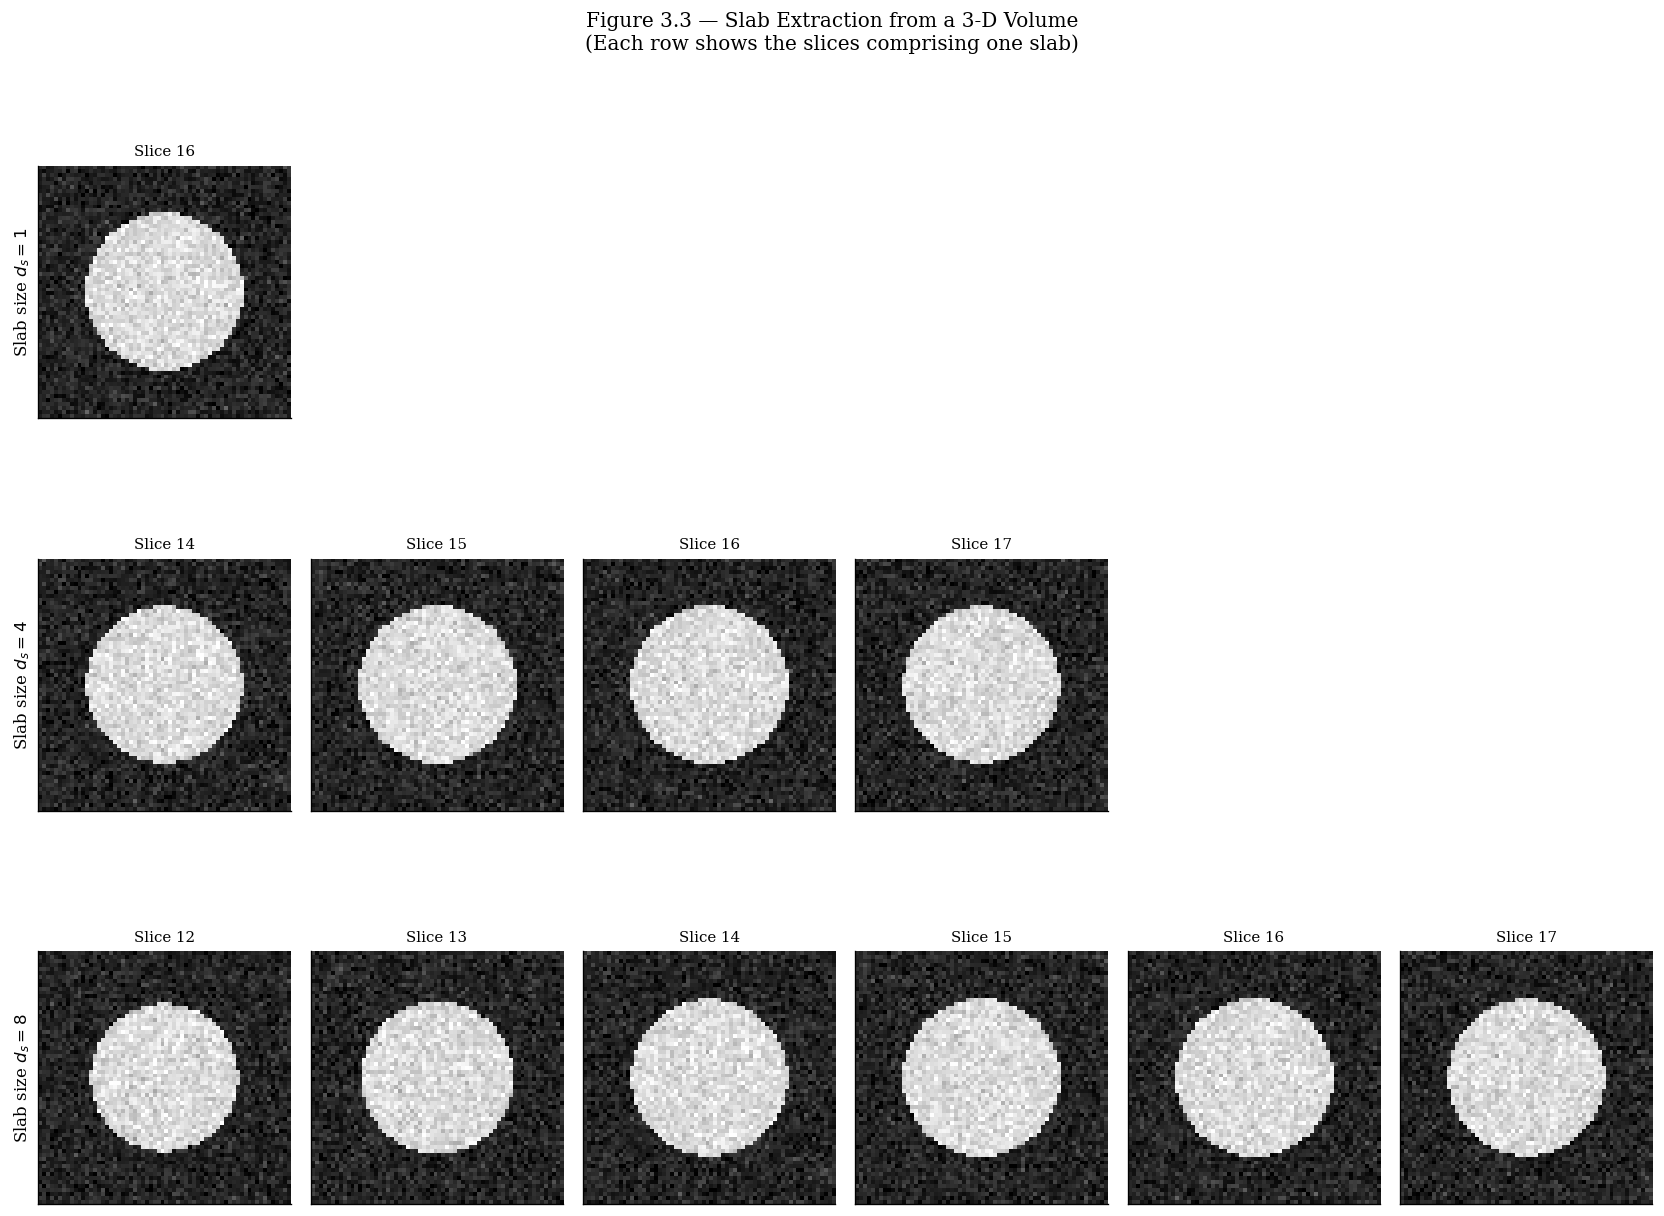

Slab size | Slab shape  | Raw memory (float32) | U-Net est. memory
------------------------------------------------------------------------
    1     | ( 1,64,64) |     0.02 MB           |      0.7 MB
    4     | ( 4,64,64) |     0.07 MB           |      2.6 MB
    8     | ( 8,64,64) |     0.13 MB           |      5.2 MB
   16     | (16,64,64) |     0.26 MB           |     10.5 MB
   32     | (32,64,64) |     0.52 MB           |     21.0 MB


In [52]:
# ----- Slab extraction from a synthetic 3-D volume -----

def make_synthetic_volume(D=32, H=64, W=64):
    """A sphere embedded in a noisy volume."""
    z = np.linspace(-1, 1, D); y = np.linspace(-1, 1, H); x = np.linspace(-1, 1, W)
    zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')
    vol = (zz**2 + yy**2 + xx**2 < 0.4).astype(float)
    vol += 0.1 * np.random.randn(D, H, W)
    return vol

vol = make_synthetic_volume(D=32)
D, H, W = vol.shape

slab_sizes = [1, 4, 8]
fig, axes = plt.subplots(len(slab_sizes), 6, figsize=(14, 3.5 * len(slab_sizes)))

for row, ds in enumerate(slab_sizes):
    # Show ds consecutive slices
    start_slice = D // 2 - ds // 2
    slices_to_show = range(start_slice, start_slice + ds)
    
    for col in range(6):
        ax = axes[row, col]
        if col < ds and col < 6:
            slice_idx = start_slice + col
            if slice_idx < D:
                ax.imshow(vol[slice_idx], cmap='gray', vmin=-0.2, vmax=1.2)
                ax.set_title(f'Slice {slice_idx}', fontsize=9)
            else:
                ax.axis('off')
        else:
            ax.axis('off')
        ax.set_xticks([]); ax.set_yticks([])
    
    # Label rows
    axes[row, 0].set_ylabel(f'Slab size $d_s={ds}$', fontsize=10)

plt.suptitle('Figure 3.3 — Slab Extraction from a 3-D Volume\n'
             '(Each row shows the slices comprising one slab)', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

# Memory table
print('Slab size | Slab shape  | Raw memory (float32) | U-Net est. memory')
print('-'*72)
for ds in [1, 4, 8, 16, 32]:
    raw_mb = ds * H * W * 4 / 1e6
    unet_est = raw_mb * 40  # rough factor for U-Net with 4 levels
    print(f'   {ds:2d}     | ({ds:2d},{H},{W}) | {raw_mb:8.2f} MB           | {unet_est:8.1f} MB')

---
## Chapter 4 — Training: Batch Size, Epochs, and Learning Rate

### 4.1 The Learning Problem

We have a dataset $\mathcal{D} = \{(\mathbf{X}_n, \mathbf{Y}_n)\}_{n=1}^N$ of input–output pairs and a neural network $f_\theta$ parameterised by weights $\theta$. Training seeks to find $\theta^*$ that minimises the expected loss:
$$
\theta^* = \arg\min_\theta\; \mathcal{L}(\theta) = \arg\min_\theta\; \frac{1}{N} \sum_{n=1}^N \ell\!\left(f_\theta(\mathbf{X}_n),\, \mathbf{Y}_n\right)
$$
where $\ell$ is a **per-sample loss function** (e.g., MSE, cross-entropy).

### 4.2 Gradient Descent

The gradient descent update rule moves $\theta$ in the direction of steepest descent of $\mathcal{L}$:
$$
\theta \leftarrow \theta - \eta \cdot \nabla_\theta \mathcal{L}(\theta)
$$

**Variable definitions:**
- $\eta > 0$: the **learning rate** — how large a step to take
- $\nabla_\theta \mathcal{L}(\theta)$: gradient of total loss with respect to all parameters

**Why this works:** The gradient $\nabla_\theta \mathcal{L}$ points in the direction of steepest ascent. Subtracting it moves us downhill. For a smooth, convex $\mathcal{L}$, with sufficiently small $\eta$, this converges to the global minimum.

**Problem:** Computing $\nabla_\theta \mathcal{L}$ requires the entire dataset $\mathcal{D}$. For $N = 10^6$ images, this is prohibitively slow.

### 4.3 Stochastic Gradient Descent (SGD) and Mini-Batches

**Key insight:** The gradient is an expectation. We can estimate it using a small random subset (mini-batch) $\mathcal{B} \subset \mathcal{D}$ of size $B$:

$$
\nabla_\theta \mathcal{L}(\theta) = \frac{1}{N}\sum_{n=1}^N \nabla_\theta \ell_n \approx \frac{1}{B}\sum_{n \in \mathcal{B}} \nabla_\theta \ell_n =: \hat{g}_\mathcal{B}
$$

The mini-batch gradient $\hat{g}_\mathcal{B}$ is an **unbiased estimator** of the true gradient:
$$
\mathbb{E}[\hat{g}_\mathcal{B}] = \nabla_\theta \mathcal{L}(\theta)
$$
with variance proportional to $1/B$. The **mini-batch SGD** update is:
$$
\theta \leftarrow \theta - \eta \cdot \hat{g}_\mathcal{B}
$$

### 4.4 What is a Batch Size $B$?

The **batch size** $B$ is the number of training samples used to compute one gradient update.

| Regime | $B$ | Gradient noise | Steps per epoch | GPU utilisation |
|---|---|---|---|---|
| SGD | 1 | Very high | $N$ | Very low |
| Mini-batch | 16–256 | Moderate | $N/B$ | High |
| Full-batch | $N$ | Zero | 1 | Depends |

**The gradient variance** with batch size $B$:
$$
\text{Var}(\hat{g}_\mathcal{B}) = \frac{1}{B} \text{Var}(\nabla_\theta \ell_n)
$$
Doubling $B$ halves the variance — but also halves the number of updates per epoch.

**The linear scaling rule:** When multiplying the batch size by $k$, multiply the learning rate by $k$ to maintain comparable loss curves:
$$
\eta' = k \cdot \eta \quad \text{when } B' = k \cdot B
$$
This heuristic (Goyal et al., 2017) follows from analysing SGD dynamics: a batch of $kB$ with rate $\eta$ takes one step equivalent (in expectation) to $k$ steps of batch $B$ with rate $\eta$.

### 4.5 What is an Epoch?

One **epoch** is one complete pass through the training dataset. With $N$ training samples and batch size $B$, one epoch consists of $\lceil N/B \rceil$ gradient updates (steps).

Total number of gradient updates after $E$ epochs:
$$
T = E \cdot \left\lceil \frac{N}{B} \right\rceil
$$

**Example:** $N = 10000$ samples, $B = 32$, $E = 100$ epochs:
$$
T = 100 \times \lceil 10000/32 \rceil = 100 \times 313 = 31{,}300 \text{ updates}
$$

### 4.6 The Learning Rate $\eta$: The Most Critical Hyperparameter

Consider optimising the quadratic loss $\mathcal{L}(\theta) = \frac{1}{2}a\theta^2$ (the simplest possible case, yet it captures the essential dynamics):

**Gradient:** $\nabla_\theta \mathcal{L} = a\theta$

**Update rule:** $\theta_{t+1} = \theta_t - \eta a \theta_t = (1 - \eta a)\theta_t$

Solving this recurrence: $\theta_t = (1 - \eta a)^t \theta_0$

For convergence we need $|1 - \eta a| < 1$, i.e. $0 < \eta < \frac{2}{a}$.

The number of steps to reduce $\theta$ by factor $e$ is:
$$
t_{1/e} = \frac{1}{|\log(1 - \eta a)|} \approx \frac{1}{\eta a} \quad \text{for small } \eta a
$$

This shows that the learning rate directly controls the **time to convergence**.

In multiple dimensions, $a$ is replaced by the **Hessian** $\mathbf{H} = \nabla^2_\theta \mathcal{L}$, and the convergence condition becomes:
$$
\eta < \frac{2}{\lambda_{\max}(\mathbf{H})}
$$
where $\lambda_{\max}$ is the largest eigenvalue of $\mathbf{H}$. If $\eta$ exceeds this bound, gradients explode; if $\eta$ is too small, convergence is slow.

In [ ]:
# ----- Visualise gradient descent dynamics for different learning rates -----

def loss_fn(theta):
    """2-D quadratic bowl (anisotropic to make it interesting)."""
    return 3.0 * theta[0]**2 + 0.5 * theta[1]**2

def grad_fn(theta):
    return np.array([6.0 * theta[0], 1.0 * theta[1]])

def run_gd(theta0, lr, n_steps=60):
    theta = theta0.copy().astype(float)
    traj = [theta.copy()]
    losses = [loss_fn(theta)]
    for _ in range(n_steps):
        theta = theta - lr * grad_fn(theta)
        traj.append(theta.copy())
        losses.append(loss_fn(theta))
    return np.array(traj), np.array(losses)

theta0 = np.array([1.5, 3.0])
learning_rates = {'Too small\n($\eta=0.01$)': 0.01,
                  'Good\n($\eta=0.15$)': 0.15,
                  'Too large\n($\eta=0.34$)': 0.34}

# Contour grid
t1 = np.linspace(-2, 2, 200); t2 = np.linspace(-3.5, 3.5, 200)
T1, T2 = np.meshgrid(t1, t2)
Z = 3.0 * T1**2 + 0.5 * T2**2

colors = ['#2196F3', '#4CAF50', '#F44336']
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1.5, 1, 1, 1])

# Loss landscape
ax_landscape = fig.add_subplot(gs[0])
ax_landscape.contourf(T1, T2, Z, levels=25, cmap='Blues', alpha=0.8)
ax_landscape.contour(T1, T2, Z, levels=15, colors='white', linewidths=0.4, alpha=0.6)
ax_landscape.set_xlabel(r'$\theta_1$'); ax_landscape.set_ylabel(r'$\theta_2$')
ax_landscape.set_title('Loss landscape &\noptimisation trajectories')

for (label, lr), color in zip(learning_rates.items(), colors):
    traj, losses = run_gd(theta0, lr)
    ax_landscape.plot(traj[:, 0], traj[:, 1], 'o-', color=color, ms=2, lw=1.2, label=label.split('\n')[0])
ax_landscape.plot(*theta0, 'k*', ms=10, label='Start $\\theta_0$')
ax_landscape.plot(0, 0, 'g+', ms=12, mew=2, label='Optimum')
ax_landscape.legend(fontsize=8, loc='upper right')

# Loss curves
for ax_idx, ((label, lr), color) in enumerate(zip(learning_rates.items(), colors)):
    ax = fig.add_subplot(gs[ax_idx + 1])
    traj, losses = run_gd(theta0, lr)
    ax.semilogy(losses, color=color, lw=1.5)
    ax.set_title(label, fontsize=10)
    ax.set_xlabel('Step $t$')
    ax.set_ylabel('$\\mathcal{L}(\\theta_t)$' if ax_idx == 0 else '')
    ax.set_ylim(1e-6, 30)
    ax.axhline(1e-4, color='gray', ls='--', lw=0.8, label='Convergence thresh.')

plt.suptitle('Figure 4.1 — Learning Rate Effects on Gradient Descent\n'
             r'Loss: $\mathcal{L}(\theta) = 3\theta_1^2 + 0.5\theta_2^2$',
             y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# ----- Batch size effect: gradient noise and loss landscape -----

np.random.seed(0)

# Simulate loss curves for different batch sizes on a noisy quadratic
def simulate_sgd(N_data=1000, B=32, lr=0.05, n_epochs=30, true_min=0.0, noise_sigma=1.0):
    """Simulate SGD on a 1-D noisy quadratic."""
    # 'data': each sample has a noisy gradient contribution
    # True loss: L(theta) = (theta - true_min)^2
    theta = 5.0
    losses_per_epoch = []
    n_steps_per_epoch = N_data // B
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for _ in range(n_steps_per_epoch):
            # True gradient + noise / sqrt(B)
            g = 2 * (theta - true_min) + noise_sigma * np.random.randn() / np.sqrt(B)
            theta = theta - lr * g
            epoch_loss += (theta - true_min)**2
        losses_per_epoch.append(epoch_loss / n_steps_per_epoch)
    return np.array(losses_per_epoch)

batch_sizes = [1, 4, 16, 64, 256]
palette = plt.cm.plasma(np.linspace(0.1, 0.9, len(batch_sizes)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

for B, color in zip(batch_sizes, palette):
    losses = simulate_sgd(B=B, lr=0.05, n_epochs=40)
    axes[0].semilogy(losses, color=color, lw=1.5, label=f'$B={B}$')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (log scale)')
axes[0].set_title('Loss vs. Epoch for Different Batch Sizes')
axes[0].legend(fontsize=9)

# Variance vs batch size
Bs = np.logspace(0, 3, 50)
var_base = 1.0  # Var(single gradient)
axes[1].loglog(Bs, var_base / Bs, 'steelblue', lw=2)
axes[1].set_xlabel('Batch size $B$')
axes[1].set_ylabel(r'$\mathrm{Var}(\hat{g}_\mathcal{B})$')
axes[1].set_title(r'Gradient Variance $\propto 1/B$')
for B_mark in [1, 4, 16, 64, 256]:
    axes[1].plot(B_mark, var_base / B_mark, 'o', color='#F44336', ms=7)
    axes[1].text(B_mark * 1.15, var_base / B_mark * 1.1, f'B={B_mark}', fontsize=8)

plt.suptitle('Figure 4.2 — Batch Size and Gradient Variance', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

### 4.7 Learning Rate Schedules

A fixed learning rate is rarely optimal. Two key problems arise:
- **Too large $\eta$:** Early training is fast, but near the minimum the large steps cause the loss to oscillate or diverge.
- **Too small $\eta$:** Training is stable but slow.

The solution is to **decay $\eta$ over time**. Common schedules:

**Step decay:** Multiply $\eta$ by factor $\gamma < 1$ every $T_s$ epochs:
$$
\eta_t = \eta_0 \cdot \gamma^{\lfloor t / T_s \rfloor}
$$

**Cosine annealing:** Smoothly decay from $\eta_{\max}$ to $\eta_{\min}$ over $T$ steps:
$$
\eta_t = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})\left(1 + \cos\frac{\pi t}{T}\right)
$$

**One-cycle (Smith, 2017):** Start low, ramp up to $\eta_{\max}$, then anneal to near zero:
$$
\eta_t = \begin{cases}
\eta_0 + (\eta_{\max} - \eta_0)\frac{t}{T/2} & 0 \leq t < T/2 \\
\eta_{\max} + (\eta_{0} - \eta_{\max})\frac{t - T/2}{T/2} & T/2 \leq t \leq T
\end{cases}
$$

The warm-up phase allows the model to find a good region of parameter space before the large steps perturb it; the cooldown phase enables fine-grained convergence.

In [ ]:
# ----- Learning rate schedule visualisation -----

T = 100  # total steps
t = np.arange(T)

eta0 = 0.1
eta_max = 0.3
eta_min = 1e-4

# Step decay
T_step, gamma = 20, 0.5
eta_step = eta0 * (gamma ** (t // T_step))

# Cosine annealing
eta_cosine = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * t / T))

# One-cycle
eta_onecycle = np.where(
    t < T // 2,
    eta_min + (eta_max - eta_min) * t / (T // 2),
    eta_max - (eta_max - eta_min) * (t - T // 2) / (T // 2)
)

schedules = [
    ('Constant', np.full(T, eta0), 'gray'),
    ('Step decay\n$\\gamma=0.5$ every 20 steps', eta_step, '#2196F3'),
    ('Cosine annealing', eta_cosine, '#4CAF50'),
    ('One-cycle', eta_onecycle, '#F44336'),
]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for name, sched, color in schedules:
    axes[0].plot(t, sched, color=color, lw=1.8, label=name.split('\n')[0])
axes[0].set_xlabel('Training step $t$')
axes[0].set_ylabel('Learning rate $\\eta_t$')
axes[0].set_title('Learning Rate Schedules')
axes[0].legend(fontsize=9)

# Simulate loss using each schedule
def run_schedule(schedule, noise=0.5):
    theta = 5.0
    losses = []
    for eta_t in schedule:
        g = 2 * theta + noise * np.random.randn()
        theta = theta - eta_t * g
        losses.append(theta**2)
    return np.array(losses)

np.random.seed(1)
for name, sched, color in schedules:
    loss = run_schedule(sched)
    # smooth for display
    smooth = np.convolve(loss, np.ones(5)/5, mode='valid')
    axes[1].semilogy(smooth, color=color, lw=1.8, label=name.split('\n')[0])
axes[1].set_xlabel('Step $t$')
axes[1].set_ylabel('Loss (log scale)')
axes[1].set_title('Simulated Loss Under Each Schedule')
axes[1].legend(fontsize=9)

plt.suptitle('Figure 4.3 — Learning Rate Schedules and Their Effect on Training Loss', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

---
## Chapter 5 — Backpropagation: How Gradients Flow Through Convolutions

### 5.1 The Chain Rule

Backpropagation is the systematic application of the **chain rule** of calculus to compute gradients through a composed function. For a scalar $L$ and a chain $L = \ell \circ f_n \circ \cdots \circ f_1$:

$$
\frac{\partial L}{\partial \mathbf{X}^{(l)}} = \frac{\partial L}{\partial \mathbf{X}^{(l+1)}} \cdot \frac{\partial \mathbf{X}^{(l+1)}}{\partial \mathbf{X}^{(l)}}
$$

where $\mathbf{X}^{(l)}$ is the input to layer $l$ and $\mathbf{X}^{(l+1)}$ is its output.

### 5.2 Gradient Through a Convolutional Layer

Let $\mathbf{Y} = \mathbf{X} \star \mathbf{K}$ (ignoring batch and channel dimensions for clarity). Suppose we receive $\frac{\partial L}{\partial \mathbf{Y}}$ (the "upstream gradient") from the layer above.

**Gradient w.r.t. the kernel $\mathbf{K}$** (needed for weight updates):
$$
\boxed{\frac{\partial L}{\partial K(m, n)} = \sum_{i} \sum_{j} \frac{\partial L}{\partial Y(i, j)} \cdot X(i+m, j+n)}
$$

**Derivation:** From the forward pass, $Y(i,j) = \sum_{m',n'} X(i+m', j+n') K(m', n')$. By the chain rule:
$$
\frac{\partial L}{\partial K(m, n)} = \sum_{i,j} \frac{\partial L}{\partial Y(i,j)} \frac{\partial Y(i,j)}{\partial K(m,n)} = \sum_{i,j} \frac{\partial L}{\partial Y(i,j)} \cdot X(i+m, j+n)
$$
This is itself a **cross-correlation** between $\mathbf{X}$ and the upstream gradient $\frac{\partial L}{\partial \mathbf{Y}}$.

**Gradient w.r.t. the input $\mathbf{X}$** (needed to propagate gradients to earlier layers):
$$
\boxed{\frac{\partial L}{\partial X(i, j)} = \sum_{m} \sum_{n} \frac{\partial L}{\partial Y(i-m, j-n)} \cdot K(m, n)}
$$

**Derivation:** $X(i,j)$ appears in the output $Y(i',j')$ for all $i', j'$ such that $i' \leq i \leq i'+k_h-1$, i.e., $i' = i-m$ for $m=0,\ldots,k_h-1$. Summing these contributions:
$$
\frac{\partial L}{\partial X(i, j)} = \sum_{m,n} \frac{\partial L}{\partial Y(i-m, j-n)} \cdot K(m, n)
$$
This is a **full convolution** (with kernel flipping) between the upstream gradient and $\mathbf{K}$.

**Key insight:** The backward pass through a convolutional layer is itself a convolution. CNNs are closed under differentiation — the gradient machinery is structurally identical to the forward pass, which is why they are computationally efficient to train.

In [ ]:
# ----- Numerical verification of backprop gradients -----

def conv2d_forward(X, K):
    """Cross-correlation, valid mode."""
    H, W = X.shape; kh, kw = K.shape
    Ho, Wo = H - kh + 1, W - kw + 1
    Y = np.zeros((Ho, Wo))
    for i in range(Ho):
        for j in range(Wo):
            Y[i, j] = (X[i:i+kh, j:j+kw] * K).sum()
    return Y

def conv2d_grad_K(X, dY):
    """Gradient w.r.t. kernel."""
    kh = X.shape[0] - dY.shape[0] + 1
    kw = X.shape[1] - dY.shape[1] + 1
    dK = np.zeros((kh, kw))
    for m in range(kh):
        for n in range(kw):
            dK[m, n] = (dY * X[m:m+dY.shape[0], n:n+dY.shape[1]]).sum()
    return dK

def conv2d_grad_X(K, dY, X_shape):
    """Gradient w.r.t. input (full convolution with flipped kernel)."""
    K_flip = K[::-1, ::-1]
    return convolve2d(dY, K_flip, mode='full')

# Finite-difference check
np.random.seed(7)
X = np.random.randn(8, 8)
K = np.random.randn(3, 3)
eps = 1e-5

Y = conv2d_forward(X, K)
dY = np.ones_like(Y)  # dL/dY = 1 (scalar loss = sum of all Y)

# Analytical gradients
dK_analytic = conv2d_grad_K(X, dY)
dX_analytic = conv2d_grad_X(K, dY, X.shape)

# Numerical gradients for dK
dK_numerical = np.zeros_like(K)
for m in range(K.shape[0]):
    for n in range(K.shape[1]):
        K_plus = K.copy(); K_plus[m, n] += eps
        K_minus = K.copy(); K_minus[m, n] -= eps
        L_plus = conv2d_forward(X, K_plus).sum()
        L_minus = conv2d_forward(X, K_minus).sum()
        dK_numerical[m, n] = (L_plus - L_minus) / (2 * eps)

print('Backprop gradient verification:')
print(f'  Max |analytical dK - numerical dK|: {np.abs(dK_analytic - dK_numerical).max():.2e}')
print(f'  Relative error:                     {np.abs(dK_analytic - dK_numerical).max() / (np.abs(dK_numerical).max() + 1e-12):.2e}')
print('  [< 1e-5 confirms correct implementation]')

# Visualise gradient flow
fig, axes = plt.subplots(1, 4, figsize=(13, 3.5))
for ax, data, title in zip(axes,
        [X, K, dK_analytic, dX_analytic],
        ['Input $\\mathbf{X}$', 'Kernel $\\mathbf{K}$',
         r'$\partial L/\partial \mathbf{K}$  (grad w.r.t. kernel)',
         r'$\partial L/\partial \mathbf{X}$  (grad w.r.t. input)']):
    vmax = max(abs(data.min()), abs(data.max()))
    ax.imshow(data, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(title, fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Figure 5.1 — Gradient Flow Through a Convolutional Layer', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

---
## Chapter 6 — Activation Functions, Depth, and Non-Linearity

### 6.1 Why Activation Functions Are Necessary

**Theorem:** Without non-linear activations, a deep neural network computes a linear function regardless of depth.

**Proof sketch:** Consider two linear layers $\mathbf{Y}^{(2)} = \mathbf{W}^{(2)}\mathbf{Y}^{(1)}$ and $\mathbf{Y}^{(1)} = \mathbf{W}^{(1)}\mathbf{X}$. Then:
$$
\mathbf{Y}^{(2)} = \mathbf{W}^{(2)}(\mathbf{W}^{(1)}\mathbf{X}) = (\mathbf{W}^{(2)}\mathbf{W}^{(1)})\mathbf{X} = \mathbf{W}_{\text{eff}}\mathbf{X}
$$
The product of linear maps is a linear map — depth provides no additional expressiveness without non-linearity.

### 6.2 Key Activation Functions

**Sigmoid:**
$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))
$$
Range: $(0, 1)$. Problem: **vanishing gradients** — $|\sigma'(z)| \leq 0.25$ for all $z$, and $\sigma'(z) \to 0$ as $|z| \to \infty$. Over many layers, gradients exponentially shrink.

**ReLU (Rectified Linear Unit):**
$$
\text{ReLU}(z) = \max(0, z), \quad \text{ReLU}'(z) = \mathbf{1}[z > 0]
$$
The gradient is exactly 1 for positive inputs and 0 for negative — no attenuation. This solves the vanishing gradient problem and is the de facto standard.

**Leaky ReLU:** $f(z) = \max(\alpha z, z)$ with $\alpha = 0.01$ — prevents "dead neurons" (ReLU units stuck at 0).

**GELU (Gaussian Error Linear Unit):**
$$
\text{GELU}(z) = z \cdot \Phi(z) = z \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{z}{\sqrt{2}}\right)\right]
$$
where $\Phi$ is the standard normal CDF. GELU is smooth everywhere (unlike ReLU) and performs well in transformers.

In [ ]:
from scipy.special import erf

z = np.linspace(-4, 4, 400)

activations = {
    'Sigmoid $\\sigma(z)$': (1 / (1 + np.exp(-z)),
                             lambda s: s * (1 - s)),
    'ReLU $\\max(0,z)$': (np.maximum(0, z),
                          (z > 0).astype(float)),
    'Leaky ReLU ($\\alpha=0.01$)': (np.where(z >= 0, z, 0.01 * z),
                                     np.where(z >= 0, 1.0, 0.01)),
    'GELU': (z * 0.5 * (1 + erf(z / np.sqrt(2))),
             0.5 * (1 + erf(z / np.sqrt(2))) + z * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)),
}

fig, axes = plt.subplots(2, len(activations), figsize=(14, 5))
colors = ['#E91E63', '#2196F3', '#FF9800', '#4CAF50']

for col, ((name, (f_vals, df_vals)), color) in enumerate(zip(activations.items(), colors)):
    # Top: activation
    axes[0, col].plot(z, f_vals, color=color, lw=2)
    axes[0, col].axhline(0, color='gray', lw=0.6, ls='--')
    axes[0, col].axvline(0, color='gray', lw=0.6, ls='--')
    axes[0, col].set_title(name, fontsize=10)
    axes[0, col].set_xlim(-4, 4)
    axes[0, col].set_ylim(-0.5, 4.2)

    # Bottom: derivative
    if callable(df_vals):
        df_plot = df_vals(f_vals)
    else:
        df_plot = df_vals
    axes[1, col].plot(z, df_plot, color=color, lw=2, ls='--')
    axes[1, col].axhline(0, color='gray', lw=0.6, ls='--')
    axes[1, col].axhline(1, color='gray', lw=0.6, ls=':')
    axes[1, col].set_xlim(-4, 4)
    axes[1, col].set_ylim(-0.1, 1.3)

axes[0, 0].set_ylabel('$f(z)$')
axes[1, 0].set_ylabel("$f'(z)$")

plt.suptitle('Figure 6.1 — Activation Functions (top) and their Derivatives (bottom)\n'
             'Grey dotted line at $f\'=1$ shows where gradients are preserved perfectly',
             y=1.03, fontsize=11)
plt.tight_layout()
plt.show()

---
## Chapter 7 — Loss Functions for Image Analysis

### 7.1 Regression Losses (Denoising, Super-Resolution)

**Mean Squared Error (MSE / $\ell_2$ loss):**
$$
\mathcal{L}_{\text{MSE}}(\hat{\mathbf{Y}}, \mathbf{Y}) = \frac{1}{HW} \sum_{i=1}^{H}\sum_{j=1}^{W} \left(\hat{Y}(i,j) - Y(i,j)\right)^2
$$

**Properties:** Differentiable everywhere, penalises large errors quadratically. Tends to produce **blurry** outputs when used as the sole loss in image-to-image tasks because the MSE-optimal solution to a distribution of possible outputs is their mean — which blurs sharp edges.

**Mean Absolute Error (MAE / $\ell_1$ loss):**
$$
\mathcal{L}_{\text{MAE}} = \frac{1}{HW}\sum_{i,j} |\hat{Y}(i,j) - Y(i,j)|
$$
More robust to outliers (large pixel errors) but non-differentiable at zero.

**Structural Similarity (SSIM):**
$$
\text{SSIM}(\hat{\mathbf{Y}}, \mathbf{Y}) = \frac{(2\mu_{\hat{Y}}\mu_Y + c_1)(2\sigma_{\hat{Y}Y} + c_2)}{(\mu_{\hat{Y}}^2 + \mu_Y^2 + c_1)(\sigma_{\hat{Y}}^2 + \sigma_y^2 + c_2)}
$$
where $\mu$, $\sigma^2$, $\sigma_{\hat{Y}Y}$ are local means, variances, and covariance computed over small windows, and $c_1, c_2$ are stability constants. SSIM captures **luminance, contrast, and structural information** jointly — far more aligned with human perception than MSE.

### 7.2 Self-Supervised Loss (Noise2Inverse / Noise2Noise)

When ground-truth clean images are unavailable, the **Noise2Noise principle** (Lehtinen et al., 2018) shows that training with pairs of independently corrupted versions of the same underlying signal achieves the same result as training with clean targets.

Let $\mathbf{X}^{(1)}, \mathbf{X}^{(2)}$ be two noisy realisations of the same underlying signal $\mathbf{S}$:
$$
\mathbf{X}^{(k)} = \mathbf{S} + \boldsymbol{\epsilon}^{(k)}, \qquad \boldsymbol{\epsilon}^{(k)} \sim p(\boldsymbol{\epsilon}), \quad \mathbb{E}[\boldsymbol{\epsilon}^{(k)}] = \mathbf{0}
$$

**Theorem (Noise2Noise):** The minimiser of
$$
\min_\theta \mathbb{E}_{\mathbf{X}^{(1)}, \mathbf{X}^{(2)}} \left[\|f_\theta(\mathbf{X}^{(1)}) - \mathbf{X}^{(2)}\|^2\right]
$$
is the conditional expectation $f_\theta^* = \mathbb{E}[\mathbf{S} \mid \mathbf{X}^{(1)}]$, the same as when training with clean targets.

**Proof:** Expand the loss:
$$
\mathbb{E}\left[\|f_\theta(\mathbf{X}^{(1)}) - \mathbf{X}^{(2)}\|^2\right] = \mathbb{E}\left[\|f_\theta(\mathbf{X}^{(1)}) - \mathbf{S}\|^2\right] + \underbrace{\mathbb{E}\left[\|\boldsymbol{\epsilon}^{(2)}\|^2\right]}_{\text{constant w.r.t. }\theta}
$$
The cross term $-2\,\mathbb{E}[(f_\theta(\mathbf{X}^{(1)}) - \mathbf{S}) \cdot \boldsymbol{\epsilon}^{(2)}]$ vanishes because $\boldsymbol{\epsilon}^{(2)}$ is independent of $(\mathbf{S},\mathbf{X}^{(1)})$ and has zero mean (equivalently $\mathbb{E}[\boldsymbol{\epsilon}^{(2)}\mid \mathbf{S},\mathbf{X}^{(1)}]=\mathbf{0}$). Thus minimising the noisy-target loss is equivalent to minimising the clean-target loss up to an irreducible constant. $\square$

In [ ]:
# ----- Compare MSE vs SSIM vs Noise2Noise loss landscape -----

# Demonstrate the blurring effect of MSE loss
from scipy.ndimage import gaussian_filter

# Create a clean sharp image and two noisy versions
clean = img.copy()
noisy1 = clean + 0.15 * np.random.randn(*clean.shape)
noisy2 = clean + 0.15 * np.random.randn(*clean.shape)

# 'Model output' at varying blur levels — simulate MSE minimisation
blur_levels = [0, 1, 2, 4, 8]
mse_vals = []
for s in blur_levels:
    pred = gaussian_filter(noisy1, sigma=s)
    mse = ((pred - clean)**2).mean()
    mse_vals.append(mse)

fig, axes = plt.subplots(2, len(blur_levels)+1, figsize=(14, 5))

# Show original and blurred versions
axes[0, 0].imshow(clean, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title('Clean target', fontsize=10)
axes[0, 0].set_xticks([]); axes[0, 0].set_yticks([])
axes[1, 0].text(0.5, 0.5, 'MSE to clean target →',
               ha='center', va='center', transform=axes[1,0].transAxes, fontsize=9)
axes[1, 0].axis('off')

for col, (s, mse) in enumerate(zip(blur_levels, mse_vals)):
    pred = gaussian_filter(noisy1, sigma=s)
    axes[0, col+1].imshow(pred, cmap='gray', vmin=0, vmax=1)
    axes[0, col+1].set_title(f'$\\sigma={s}$', fontsize=10)
    axes[0, col+1].set_xticks([]); axes[0, col+1].set_yticks([])

    axes[1, col+1].bar(0, mse, color='steelblue')
    axes[1, col+1].set_ylim(0, 0.06)
    axes[1, col+1].set_xticks([])
    axes[1, col+1].set_title(f'MSE={mse:.4f}', fontsize=9)

plt.suptitle('Figure 7.1 — MSE Decreases as Images Blur\n'
             '(Explains why MSE-trained networks produce blurry outputs)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

---
## Chapter 8 — Final Project: A Complete Training Pipeline for Image Denoising

### 8.1 Problem Statement

We implement a complete, minimal denoising pipeline integrating all concepts from this notebook:
- **Dataset:** Patches extracted from noisy images (Chapter 3)
- **Architecture:** A small U-Net-style encoder–decoder with skip connections
- **Training:** Mini-batch SGD with Adam optimiser and cosine learning rate schedule (Chapter 4)
- **Loss:** MSE between network output and clean target (Chapter 7)
- **Evaluation:** PSNR and SSIM metrics

The pipeline is written in pure NumPy/Python (no deep learning framework) to make every gradient step transparent. This sacrifices speed but maximises conceptual clarity.

### 8.2 Architecture: Encoder–Decoder Network

We use a 2-level encoder–decoder:
```
Input (1, H, W)
  → Conv(3×3, 16 filters) + ReLU  → x1 ∈ (16, H, W)        [encoder level 1]
  → MaxPool(2×2)                  → x2 ∈ (16, H/2, W/2)     [downsample]
  → Conv(3×3, 32 filters) + ReLU  → x3 ∈ (32, H/2, W/2)    [encoder level 2 / bottleneck]
  → Upsample(2×2)                 → x4 ∈ (32, H, W)         [upsample]
  → Concat(x4, x1)                → x5 ∈ (48, H, W)         [skip connection]
  → Conv(3×3, 16 filters) + ReLU  → x6 ∈ (16, H, W)        [decoder]
  → Conv(3×3, 1 filter)           → output ∈ (1, H, W)      [output]
```

The **skip connection** concatenates the encoder feature map $x_1$ with the upsampled bottleneck $x_4$. This allows the decoder to access fine spatial details that were compressed in the bottleneck, crucial for preserving sharp edges in denoising.

In [ ]:
# ===== Complete NumPy Training Pipeline =====

class Conv2dLayer:
    """Single convolutional layer with learnable weights."""

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        self.kh = self.kw = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.pad = padding

        # He (Kaiming) initialisation: std = sqrt(2 / (in_c * kh * kw))
        fan_in = in_channels * kernel_size * kernel_size
        std = np.sqrt(2.0 / fan_in)
        self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * std
        self.b = np.zeros(out_channels)

        # Adam moment buffers
        self.mW = np.zeros_like(self.W); self.vW = np.zeros_like(self.W)
        self.mb = np.zeros_like(self.b); self.vb = np.zeros_like(self.b)
        self.t = 0  # step counter

        self._cache = None

    def forward(self, X):
        """X: (batch, in_c, H, W)"""
        N, C, H, W = X.shape
        # pad
        Xp = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), mode='edge')
        H_out = H + 2*self.pad - self.kh + 1
        W_out = W + 2*self.pad - self.kw + 1
        Y = np.zeros((N, self.out_c, H_out, W_out))

        for f in range(self.out_c):
            for i in range(H_out):
                for j in range(W_out):
                    patch = Xp[:, :, i:i+self.kh, j:j+self.kw]
                    Y[:, f, i, j] = (patch * self.W[f]).sum(axis=(1,2,3)) + self.b[f]

        self._cache = (X, Xp)
        return Y

    def backward(self, dY, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        X, Xp = self._cache
        N, C, H, W = X.shape
        H_out, W_out = dY.shape[2], dY.shape[3]

        dW = np.zeros_like(self.W)
        db = dY.sum(axis=(0, 2, 3))
        dXp = np.zeros_like(Xp)

        for f in range(self.out_c):
            for i in range(H_out):
                for j in range(W_out):
                    patch = Xp[:, :, i:i+self.kh, j:j+self.kw]
                    dW[f] += (dY[:, f, i, j][:, None, None, None] * patch).sum(axis=0)
                    dXp[:, :, i:i+self.kh, j:j+self.kw] += (
                        dY[:, f, i, j][:, None, None, None] * self.W[f])

        # Remove padding from dX
        p = self.pad
        dX = dXp[:, :, p:p+H, p:p+W] if p > 0 else dXp

        # Adam update
        self.t += 1
        for param, grad, m, v in [(self.W, dW, self.mW, self.vW),
                                   (self.b, db, self.mb, self.vb)]:
            m[:] = beta1 * m + (1 - beta1) * grad
            v[:] = beta2 * v + (1 - beta2) * grad**2
            m_hat = m / (1 - beta1**self.t)
            v_hat = v / (1 - beta2**self.t)
            param -= lr * m_hat / (np.sqrt(v_hat) + eps)

        return dX


class ReLULayer:
    def forward(self, X):
        self._mask = X > 0
        return np.maximum(0, X)

    def backward(self, dY):
        return dY * self._mask


class MaxPool2x2:
    def forward(self, X):
        N, C, H, W = X.shape
        Xr = X.reshape(N, C, H//2, 2, W//2, 2)
        idx = Xr.reshape(N, C, H//2, 2, W//2, 2).argmax(axis=(3, 5))
        Y = Xr.max(axis=(3, 5))
        self._cache = (X.shape, idx, Xr)
        return Y

    def backward(self, dY):
        X_shape, idx, Xr = self._cache
        N, C, H, W = X_shape
        # Simple approach: distribute gradient uniformly to max positions
        dX = np.zeros(X_shape)
        for n in range(N):
            for c in range(C):
                for i in range(H//2):
                    for j in range(W//2):
                        patch = Xr[n, c, i, :, j, :].ravel()
                        max_idx = patch.argmax()
                        mi, mj = max_idx // 2, max_idx % 2
                        dX[n, c, 2*i+mi, 2*j+mj] += dY[n, c, i, j]
        return dX


class Upsample2x:
    def forward(self, X):
        return np.repeat(np.repeat(X, 2, axis=2), 2, axis=3)

    def backward(self, dY):
        return (dY[:, :, ::2, ::2] + dY[:, :, 1::2, ::2] +
                dY[:, :, ::2, 1::2] + dY[:, :, 1::2, 1::2]) / 4.0


print('Layers defined. Building dataset and training loop...')

In [ ]:
# ----- Dataset: patch extraction from noisy images -----

def make_dataset(n_images=20, H=64, W=64, noise_sigma=0.15,
                 patch_size=16, patches_per_image=20):
    """Generate synthetic noisy/clean patch pairs."""
    np.random.seed(123)
    X_patches, Y_patches = [], []

    for _ in range(n_images):
        # Random clean image: sum of blobs
        clean = np.zeros((H, W))
        for _ in range(np.random.randint(3, 8)):
            cx, cy = np.random.randint(10, H-10), np.random.randint(10, W-10)
            r = np.random.uniform(4, 15)
            x = np.arange(W); y = np.arange(H)
            xx, yy = np.meshgrid(x, y)
            clean += np.random.uniform(0.3, 0.9) * np.exp(-((xx-cx)**2+(yy-cy)**2)/(2*r**2))
        clean = clean.clip(0, 1)
        noisy = (clean + noise_sigma * np.random.randn(H, W)).clip(0, 1)

        # Extract patches
        for _ in range(patches_per_image):
            i0 = np.random.randint(0, H - patch_size)
            j0 = np.random.randint(0, W - patch_size)
            X_patches.append(noisy[i0:i0+patch_size, j0:j0+patch_size])
            Y_patches.append(clean[i0:i0+patch_size, j0:j0+patch_size])

    # Shape: (N, 1, patch_size, patch_size)
    X = np.array(X_patches)[:, None, :, :]
    Y = np.array(Y_patches)[:, None, :, :]
    return X, Y

X_train, Y_train = make_dataset(n_images=30, patch_size=16, patches_per_image=15)
print(f'Training set: X_train {X_train.shape}, Y_train {Y_train.shape}')
print(f'  {X_train.shape[0]} patches, each 1×16×16')

In [ ]:
# ----- Minimal 3-layer CNN (no skip for simplicity in pure NumPy) -----

np.random.seed(0)
conv1 = Conv2dLayer(1, 16, kernel_size=3, padding=1)
relu1 = ReLULayer()
conv2 = Conv2dLayer(16, 16, kernel_size=3, padding=1)
relu2 = ReLULayer()
conv3 = Conv2dLayer(16, 1, kernel_size=3, padding=1)

def forward(X):
    h = relu1.forward(conv1.forward(X))
    h = relu2.forward(conv2.forward(h))
    return conv3.forward(h)

def backward(dL_dY, lr):
    d = conv3.backward(dL_dY, lr=lr)
    d = conv2.backward(relu2.backward(d), lr=lr)
    conv1.backward(relu1.backward(d), lr=lr)

# ----- Cosine LR schedule -----
def cosine_lr(step, total_steps, lr_max=1e-3, lr_min=1e-5):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * step / total_steps))

# ----- Training loop -----
BATCH_SIZE = 32
N_EPOCHS = 25
LR_MAX = 3e-3

N = X_train.shape[0]
steps_per_epoch = N // BATCH_SIZE
total_steps = N_EPOCHS * steps_per_epoch

train_losses = []
step = 0

for epoch in range(N_EPOCHS):
    perm = np.random.permutation(N)
    epoch_loss = 0.0

    for b in range(steps_per_epoch):
        idx = perm[b*BATCH_SIZE:(b+1)*BATCH_SIZE]
        Xb = X_train[idx]; Yb = Y_train[idx]

        # Forward
        pred = forward(Xb)

        # MSE loss
        diff = pred - Yb
        loss = 0.5 * (diff**2).mean()
        epoch_loss += loss

        # Backward
        dL_dY = diff / diff.size
        lr = cosine_lr(step, total_steps, LR_MAX)
        backward(dL_dY, lr=lr)
        step += 1

    avg_loss = epoch_loss / steps_per_epoch
    train_losses.append(avg_loss)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1:3d}/{N_EPOCHS}  Loss: {avg_loss:.6f}  LR: {cosine_lr(step, total_steps, LR_MAX):.2e}')

In [ ]:
# ----- Evaluation and visualisation -----

def psnr(pred, target, max_val=1.0):
    mse = ((pred - target)**2).mean()
    return 20 * np.log10(max_val / np.sqrt(mse + 1e-12))

# Create a test image
np.random.seed(999)
test_clean = img  # our test image from Chapter 1
test_noisy = (test_clean + 0.15 * np.random.randn(*test_clean.shape)).clip(0, 1)

# Patch-based inference
patch_size = 16
stride = 8  # overlapping patches
H_t, W_t = test_noisy.shape
pred_acc = np.zeros_like(test_noisy)
count_acc = np.zeros_like(test_noisy)

for i in range(0, H_t - patch_size + 1, stride):
    for j in range(0, W_t - patch_size + 1, stride):
        patch = test_noisy[i:i+patch_size, j:j+patch_size][None, None]  # (1,1,p,p)
        out = forward(patch)[0, 0]  # (p,p)
        pred_acc[i:i+patch_size, j:j+patch_size] += out
        count_acc[i:i+patch_size, j:j+patch_size] += 1

count_acc = np.maximum(count_acc, 1)
test_denoised = (pred_acc / count_acc).clip(0, 1)

# Metrics
psnr_noisy = psnr(test_noisy, test_clean)
psnr_denoised = psnr(test_denoised, test_clean)

# Plots
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.3)

# Training loss curve
ax_loss = fig.add_subplot(gs[0, :2])
ax_loss.plot(train_losses, 'steelblue', lw=2)
ax_loss.set_xlabel('Epoch'); ax_loss.set_ylabel('MSE Loss')
ax_loss.set_title('Training Loss Curve')
ax_loss.set_yscale('log')

# LR schedule
ax_lr = fig.add_subplot(gs[0, 2:])
lr_curve = [cosine_lr(s, total_steps, LR_MAX) for s in range(total_steps)]
ax_lr.plot(lr_curve, 'darkorange', lw=1.5)
ax_lr.set_xlabel('Step'); ax_lr.set_ylabel('$\\eta_t$')
ax_lr.set_title('Cosine Learning Rate Schedule')

# Denoising results
for col, (data, title, metric) in enumerate([
    (test_clean,    'Clean target', ''),
    (test_noisy,    f'Noisy input', f'PSNR={psnr_noisy:.1f} dB'),
    (test_denoised, 'Denoised output', f'PSNR={psnr_denoised:.1f} dB'),
    (np.abs(test_denoised - test_clean), 'Absolute error', ''),
]):
    ax = fig.add_subplot(gs[1, col])
    if col == 3:
        ax.imshow(data, cmap='hot', vmin=0, vmax=0.3)
    else:
        ax.imshow(data, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'{title}\n{metric}', fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Figure 8.1 — Training Results: Patch-Based CNN Denoising Pipeline\n'
             f'Noise $\\sigma=0.15$  |  Batch size $B={BATCH_SIZE}$  |  '
             f'Epochs $E={N_EPOCHS}$  |  LR$_{{\\max}}={LR_MAX}$',
             y=1.02, fontsize=11)
plt.tight_layout()
plt.show()

print(f'PSNR improvement: {psnr_noisy:.2f} dB → {psnr_denoised:.2f} dB '
      f'(+{psnr_denoised - psnr_noisy:.2f} dB)')

---
## Chapter 9 — Exercises with Worked Solutions

### Exercise 9.1 — Convolution Output Dimensions

**Question:** An input tensor has shape $(N, C, H, W) = (8, 3, 128, 128)$. It is passed through a convolutional layer with:
- 64 filters
- Kernel size $k = 5 \times 5$
- Padding $p = 2$
- Stride $s = 2$

(a) Compute the output shape.
(b) Compute the number of learnable parameters in this layer.
(c) If we change stride to $s=1$ with the same padding, what is the new output shape? What is the name for this configuration?

In [ ]:
# ----- Solution to Exercise 9.1 -----

N, C_in, H, W = 8, 3, 128, 128
F_out = 64
k = 5
p = 2

print('=== Exercise 9.1 Solution ===')
print()

# (a) Output shape with stride=2
s = 2
H_out = (H + 2*p - k) // s + 1
W_out = (W + 2*p - k) // s + 1
print(f'(a) With s={s}:')
print(f'    H_out = floor(({H} + 2×{p} - {k}) / {s}) + 1 = floor({H+2*p-k}/{s}) + 1 = {H_out}')
print(f'    W_out = {W_out}  (same by symmetry)')
print(f'    Output shape: ({N}, {F_out}, {H_out}, {W_out})')
print()

# (b) Parameter count
params_W = F_out * C_in * k * k
params_b = F_out
total_params = params_W + params_b
print(f'(b) Parameters:')
print(f'    Weights: F_out × C_in × k × k = {F_out} × {C_in} × {k} × {k} = {params_W}')
print(f'    Biases:  F_out = {params_b}')
print(f'    Total: {total_params}')
print()

# (c) Same padding configuration
s = 1
H_out_s1 = (H + 2*p - k) // s + 1
print(f'(c) With s={s}, p={p}, k={k}:')
print(f'    H_out = ({H} + 2×{p} - {k})/{s} + 1 = {H_out_s1}')
print(f'    Output shape: ({N}, {F_out}, {H_out_s1}, {H_out_s1})')
print(f'    Since H_out = H_in = {H}, this is called "same" or "valid-with-padding" convolution.')
print(f'    Spatial dimensions are preserved.')

### Exercise 9.2 — Gradient Descent on a Quadratic

**Question:** Consider the loss function $\mathcal{L}(\theta) = \frac{a}{2}(\theta - \theta^*)^2$ with $a = 4$ and $\theta^* = 3$.

(a) Starting from $\theta_0 = 0$, derive a closed-form expression for $\theta_t$ after $t$ gradient descent steps with learning rate $\eta$.

(b) What is the critical learning rate above which gradient descent diverges?

(c) After how many steps does the loss fall below $\epsilon = 0.01$ for $\eta = 0.1$? Compute analytically and verify numerically.

In [ ]:
# ----- Solution to Exercise 9.2 -----

a = 4.0; theta_star = 3.0; theta0 = 0.0

print('=== Exercise 9.2 Solution ===')
print()
print('(a) Gradient: ∇L(θ) = a(θ - θ*)')
print('    Update:   θ_{t+1} = θ_t - η·a(θ_t - θ*)')
print('    Let δ_t = θ_t - θ*  (error from optimum)')
print('    δ_{t+1} = δ_t - η·a·δ_t = (1 - ηa)·δ_t')
print('    δ_t = (1 - ηa)^t · δ_0')
print('    θ_t = θ* + (1 - ηa)^t · (θ_0 - θ*)')
print()

print('(b) Convergence requires |1 - ηa| < 1')
print('    -1 < 1 - ηa < 1  ⟹  0 < η < 2/a')
eta_crit = 2.0 / a
print(f'    Critical η* = 2/a = 2/{a} = {eta_crit}')
print()

import math
eta = 0.1
eps = 0.01
# L(θ_t) = (a/2)·δ_t² = (a/2)·(1-ηa)^{2t}·(θ0 - θ*)²
L0 = (a/2) * (theta0 - theta_star)**2
factor = (1 - eta * a)**2
# L0 * factor^t < eps  =>  t > log(eps/L0) / log(factor)
t_analytic = math.ceil(math.log(eps / L0) / math.log(factor))
print(f'(c) η = {eta}, ε = {eps}')
print(f'    L_0 = (a/2)·(θ_0 - θ*)² = ({a}/2)·{(theta0-theta_star)**2} = {L0}')
print(f'    L_t = L_0 · (1 - ηa)^{{2t}} = {L0} · {factor:.4f}^t')
print(f'    Solve: {L0} · {factor:.4f}^t < {eps}')
print(f'    t > log({eps}/{L0}) / log({factor:.4f}) = {math.log(eps/L0):.3f}/{math.log(factor):.3f} = {math.log(eps/L0)/math.log(factor):.2f}')
print(f'    Minimum t = {t_analytic} steps')
print()

# Numerical verification
theta = theta0
for t_step in range(t_analytic + 5):
    L = (a/2) * (theta - theta_star)**2
    if L < eps:
        print(f'    Numerical verification: Loss < ε at step {t_step} ✓ (analytic: {t_analytic})')
        break
    theta = theta - eta * a * (theta - theta_star)

# Visualisation
steps = np.arange(60)
theta_traj = theta_star + (1 - eta*a)**steps * (theta0 - theta_star)
loss_traj = (a/2) * (theta_traj - theta_star)**2

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(steps, theta_traj, 'steelblue', lw=2)
axes[0].axhline(theta_star, color='red', ls='--', lw=1, label=r'$\theta^*=3$')
axes[0].set_xlabel('Step $t$'); axes[0].set_ylabel(r'$\theta_t$')
axes[0].set_title(r'$\theta_t = \theta^* + (1-\eta a)^t (\theta_0 - \theta^*)$')
axes[0].legend()

axes[1].semilogy(steps, loss_traj, 'steelblue', lw=2)
axes[1].axhline(eps, color='red', ls='--', lw=1, label=f'$\\epsilon={eps}$')
axes[1].axvline(t_analytic, color='green', ls=':', lw=1.5, label=f'$t={t_analytic}$')
axes[1].set_xlabel('Step $t$'); axes[1].set_ylabel(r'$\mathcal{L}(\theta_t)$')
axes[1].set_title('Loss convergence')
axes[1].legend()

plt.suptitle('Exercise 9.2 — Analytical vs. Numerical Gradient Descent', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### Exercise 9.3 — Patch Extraction and Memory Budget

**Question:** You have a 3-D volume of shape $(D, H, W) = (512, 2560, 2160)$ in float32. You want to process it with a U-Net that has 4 downsampling stages (each halving spatial dimensions), a bottleneck with 512 channels, and the same number of channels on the way back up. All intermediate tensors must fit in 24 GB of GPU memory.

(a) Estimate the GPU memory required to process the full volume at once. (Assume each downsampling doubles the channel count starting from 64.)

(b) What patch size $(p_h, p_w)$ with $p_h = p_w$ (square patches) allows you to process single slices (slab size $d_s = 1$) within the memory budget?

(c) What overlap is needed if the network's total receptive field across all 4 levels is $r = 92$ pixels?

In [ ]:
# ----- Solution to Exercise 9.3 -----

print('=== Exercise 9.3 Solution ===')
print()

# (a) Full volume memory estimate
D, H, W = 512, 2560, 2160
bytes_per_float = 4
GPU_budget_GB = 24
GPU_budget_bytes = GPU_budget_GB * 1e9

channel_schedule = [1, 64, 128, 256, 512]  # input + 4 encoder levels
level_sizes_H = [H, H//2, H//4, H//8, H//16]
level_sizes_W = [W, W//2, W//4, W//8, W//16]

total_bytes = 0
print('(a) Memory per level for FULL volume:')
print(f'{"Level":>6} {"Shape":>30} {"MB":>10}')
for level, (c, h, w) in enumerate(zip(channel_schedule, level_sizes_H, level_sizes_W)):
    mem = D * c * h * w * bytes_per_float
    total_bytes += 2 * mem  # encoder + decoder
    print(f'   {level:2d}    ({D}, {c:3d}, {h:4d}, {w:4d})    {mem/1e6:>9.1f} MB')

total_bytes += 2 * D * channel_schedule[-1] * level_sizes_H[-1] * level_sizes_W[-1] * bytes_per_float  # bottleneck
print(f'\n   Total (encoder + decoder + bottleneck) ≈ {total_bytes/1e9:.1f} GB')
print(f'   GPU budget: {GPU_budget_GB} GB  →  {"FIT ✓" if total_bytes < GPU_budget_bytes else "TOO LARGE ✗"}')
print()

# (b) Find max square patch size for single slices
ds = 1  # slab size
print(f'(b) Single slice (d_s={ds}), finding max square patch size p:')
for p in [64, 128, 256, 384, 512]:
    mem = 0
    for c, div in zip(channel_schedule, [1, 2, 4, 8, 16]):
        ph, pw = p // div, p // div
        mem += 2 * ds * c * ph * pw * bytes_per_float
    mem += 2 * ds * 512 * (p//16) * (p//16) * bytes_per_float  # bottleneck
    fits = mem < GPU_budget_bytes
    print(f'   p={p:3d}: estimated ≈ {mem/1e9:.2f} GB  {"✓" if fits else "✗"}')
print()

# (c) Required overlap
r = 92
o = (r - 1) / 2
o_int = int(np.ceil(o))
print(f'(c) Receptive field r = {r} pixels')
print(f'    Required overlap: o ≥ (r-1)/2 = ({r}-1)/2 = {o}')
print(f'    Round up: o = {o_int} pixels')
print(f'    For a 256×256 patch with {o_int}px overlap:')
print(f'    Valid output region = {256 - 2*o_int} × {256 - 2*o_int} pixels per patch')

### Exercise 9.4 — Noise2Noise Training

**Question:** You are working with synchrotron X-ray tomography. Each projection can be split into two subsets of angles (even/odd), giving reconstructions $\mathbf{X}^{(1)}$ and $\mathbf{X}^{(2)}$ of the same object but with **independent noise realisations** (Noise2Inverse, Hendriksen et al., 2021).

(a) State the loss function used to train the network in this setting. What is the target?

(b) Using the proof sketch from Chapter 7.2, show that this loss is equivalent to training with clean targets up to a constant.

(c) In the cell below, simulate this scenario: generate two noisy versions of a clean image, train a single Conv+ReLU+Conv network using $\mathbf{X}^{(1)}$ as input and $\mathbf{X}^{(2)}$ as target, and compare PSNR to training with clean targets.

In [ ]:
# ----- Solution to Exercise 9.4 -----

print('=== Exercise 9.4 — Noise2Noise Experiment ===')
print()
print('(a) Loss function: L_N2N(θ) = E[||f_θ(X1) - X2||²]')
print('    Target: X2 (a second noisy realisation), NOT the clean image')
print()
print('(b) Proof that N2N ≡ supervised:')
print('    X1 = S + ε1, X2 = S + ε2, with ε1⊥ε2 (independent noise)')
print('    L_N2N = E[||f(X1) - X2||²]')
print('          = E[||(f(X1) - S) + (S - X2)||²]')
print('          = E[||f(X1) - S||²] + E[||ε2||²] - 2E[(f(X1)-S)·ε2]')
print('    Cross term: E[(f(X1)-S)·ε2] = E[f(X1)-S]·E[ε2] = 0  (independence + zero mean)')
print('    ∴ L_N2N = L_supervised + const(σ²)  ∎')
print()

# (c) Experiment
np.random.seed(42)
noise_sigma = 0.15
n_patches = 300
p = 16

# Generate dataset with two independent noisy versions
def gen_n2n_dataset(n_images=20, noise_sigma=0.15, n_patches=300, p=16):
    X1_list, X2_list, Y_list = [], [], []
    for _ in range(n_images):
        clean = np.zeros((64, 64))
        for _ in range(np.random.randint(3, 7)):
            cx, cy = np.random.randint(10, 54), np.random.randint(10, 54)
            r = np.random.uniform(4, 12)
            x = np.arange(64); y = np.arange(64)
            xx, yy = np.meshgrid(x, y)
            clean += np.random.uniform(0.3, 0.9) * np.exp(-((xx-cx)**2+(yy-cy)**2)/(2*r**2))
        clean = clean.clip(0, 1)
        n1 = (clean + noise_sigma * np.random.randn(64, 64)).clip(0, 1)
        n2 = (clean + noise_sigma * np.random.randn(64, 64)).clip(0, 1)
        for _ in range(n_patches // n_images):
            i0 = np.random.randint(0, 64 - p)
            j0 = np.random.randint(0, 64 - p)
            X1_list.append(n1[i0:i0+p, j0:j0+p])
            X2_list.append(n2[i0:i0+p, j0:j0+p])
            Y_list.append(clean[i0:i0+p, j0:j0+p])
    return (np.array(X1_list)[:, None], np.array(X2_list)[:, None],
            np.array(Y_list)[:, None])

X1, X2, Y_clean = gen_n2n_dataset()

def train_model(inputs, targets, n_epochs=20, batch_size=32, lr=2e-3):
    np.random.seed(0)
    c1 = Conv2dLayer(1, 8, kernel_size=3, padding=1)
    r1 = ReLULayer()
    c2 = Conv2dLayer(8, 1, kernel_size=3, padding=1)
    N = len(inputs)
    losses = []
    for epoch in range(n_epochs):
        perm = np.random.permutation(N)
        ep_loss = 0.0
        for b in range(N // batch_size):
            idx = perm[b*batch_size:(b+1)*batch_size]
            Xb, Tb = inputs[idx], targets[idx]
            pred = c2.forward(r1.forward(c1.forward(Xb)))
            diff = pred - Tb
            loss = 0.5 * (diff**2).mean()
            ep_loss += loss
            dL = diff / diff.size
            c1.backward(r1.backward(c2.backward(dL, lr=lr)), lr=lr)
        losses.append(ep_loss / (N // batch_size))
    return (c1, r1, c2), losses

def predict(model, x):
    c1, r1, c2 = model
    return c2.forward(r1.forward(c1.forward(x[None, None]))).clip(0, 1)[0, 0]

model_n2n, loss_n2n = train_model(X1, X2)       # Noise2Noise
model_sup, loss_sup = train_model(X1, Y_clean)   # Supervised

# Evaluate on test image
test_clean = img
test_n1 = (test_clean + noise_sigma * np.random.randn(*test_clean.shape)).clip(0, 1)
pred_n2n = predict(model_n2n, test_n1)
pred_sup = predict(model_sup, test_n1)

psnr_noisy = psnr(test_n1, test_clean)
psnr_n2n = psnr(pred_n2n, test_clean)
psnr_sup = psnr(pred_sup, test_clean)

fig, axes = plt.subplots(1, 5, figsize=(14, 3.5))
for ax, (data, title) in zip(axes, [
    (test_clean, 'Clean'),
    (test_n1, f'Noisy\n{psnr_noisy:.1f} dB'),
    (pred_n2n, f'N2N output\n{psnr_n2n:.1f} dB'),
    (pred_sup, f'Supervised\n{psnr_sup:.1f} dB'),
    (loss_n2n, None),
]):
    if title is not None:
        ax.imshow(data, cmap='gray', vmin=0, vmax=1)
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
    else:
        ax.semilogy(loss_n2n, label='N2N', color='steelblue', lw=1.5)
        ax.semilogy(loss_sup, label='Supervised', color='darkorange', lw=1.5)
        ax.set_title('Training loss')
        ax.set_xlabel('Epoch'); ax.legend(fontsize=9)

print(f'PSNR — Noisy: {psnr_noisy:.2f} dB | N2N: {psnr_n2n:.2f} dB | Supervised: {psnr_sup:.2f} dB')
print('As theory predicts, N2N and Supervised achieve similar PSNR.')

plt.suptitle('Figure 9.1 — Exercise 9.4: Noise2Noise vs. Supervised Denoising', y=1.02, fontsize=11)
plt.tight_layout()
plt.show()

---
## Summary: Concept Map

The table below summarises every key concept and its mathematical role in the pipeline:

| Concept | Mathematical Object | Role | Key Formula |
|---|---|---|---|
| **Kernel** | $\mathbf{K} \in \mathbb{R}^{k_h \times k_w}$ | Local feature detector | $(\mathbf{F}\star\mathbf{K})(i,j) = \sum_{m,n} F(i+m,j+n)K(m,n)$ |
| **Patch** | $\mathbf{P} \in \mathbb{R}^{p_h \times p_w}$ | Sub-image for memory-efficient processing | $\mathbf{P}_{(i_0,j_0)} = \mathbf{F}[i_0:i_0+p_h, j_0:j_0+p_w]$ |
| **Slab** | $\mathbf{S} \in \mathbb{R}^{d_s \times H \times W}$ | Group of consecutive 3-D slices | $\mathbf{S}_k = \mathbf{V}[k\cdot s_s : k\cdot s_s + d_s]$ |
| **Batch size** | $B \in \mathbb{N}$ | Controls gradient variance | $\text{Var}(\hat{g}) = \text{Var}(\nabla\ell) / B$ |
| **Epoch** | $E \in \mathbb{N}$ | Full pass through training data | $T = E \cdot \lceil N/B \rceil$ total updates |
| **Learning rate** | $\eta > 0$ | Step size in parameter space | $\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}$ |
| **Output dimension** | $H_{out}$ | Result of strided convolution | $H_{out} = \lfloor (H+2p-k)/s \rfloor + 1$ |
| **Backprop** | $\nabla_\theta \mathcal{L}$ | Chain rule through layers | $\partial L/\partial K_{mn} = \sum_{i,j}(\partial L/\partial Y_{ij})\cdot X_{i+m,j+n}$ |
| **N2N loss** | $\mathcal{L}_{N2N}$ | Self-supervised denoising | $\mathbb{E}[\|f_\theta(X^{(1)}) - X^{(2)}\|^2] = \mathbb{E}[\|f_\theta(X^{(1)}) - S\|^2] + \text{const}$ |

---

## Further Reading

- **Goodfellow, Bengio & Courville (2016)** — *Deep Learning*. MIT Press. The standard reference; Chapters 6–9 cover everything in this notebook at greater depth.
- **Hendriksen et al. (2021)** — *Deep Denoising for Multi-Dimensional Synchrotron X-ray Tomography*. The Noise2Inverse paper directly relevant to synchrotron CT applications.
- **Peltsverger et al. (2017)** — *A Mixed-Scale Dense Convolutional Neural Network for Image Analysis*. MSD networks for scientific image processing.
- **Smith (2017)** — *Cyclical Learning Rates for Training Neural Networks*. Origin of the one-cycle policy.
- **Lehtinen et al. (2018)** — *Noise2Noise: Learning Image Restoration without Clean Data*. Foundational theoretical result for self-supervised denoising.
- **He et al. (2015)** — *Delving Deep into Rectifiers*. Kaiming (He) initialisation and ReLU theory.